In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from scipy import stats
from scipy import integrate
import random
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.cosmology import WMAP9 as cosmo
import uncertainties
from uncertainties import unumpy as unp
import os

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Century Schoolbook"],
    "font.size": 18
    })


In [2]:
# define inputs

sz = 10.0            # sets search radius in degress - uses prexisting files that have results of search to X degrees
comp_limit = 0.2     # required minimum completeness fraction to avoid using UDGs that have very high completeness corrections
min_sep = 0.02       # minimum physical separation for pairs (to avoid working too close where other incompleteness sets in) units Mpc
max_sep = 10
blue_color_lower = 0.2
upper_color = 0.75   # objects redder than upper_color are considered interlopers

bin_norm = 15       # number of bins within 1 Mpc for histograms

# minimum & maximimum sample redshift
min_z = 4500/3e5
max_z = 5500/3e5

udg_mag_cutoff = -15.0  # Cut off of bright and faint UDGs in the middle (of UDGs' absolute magnitude)
udg_mag_upper = -16.5    # upper and lower define a magnitude bin to work with
udg_mag_lower = -15.5

avg_z = (min_z+max_z)/2
survey_area = 20000  # survey area in sq. degrees
r_out = 0.25         # outer radius for integration (to get satellite counts within min_sep and r_out) units Mpc

lower = .16          # Defines lower percentage; .16 = 16% for error bounds on number of satellites
upper = .84          # Defines upper percentage; .84 = 84% for error bounds on number of satellites

mag_upper = -22      # limits to define MW analogs in g band
mag_lower = -20

# define fiducial red sequence
popt_lin_all = [0, 0]
popt_lin_all[0] = -0.03054506842951515 
popt_lin_all[1] =  0.16749310166518655 


In [3]:
os.chdir( '/home/jail/dlusers/hina0830/notebooks/01_GettingStartedWithDataLab' + '/' + 'dim_bright' )
os.getcwd()

'/home/jail/dlusers/hina0830/notebooks/01_GettingStartedWithDataLab/dim_bright'

In [4]:
def lin_all(x, a, b):
    print(a, b)
    return a*x + b

In [5]:
pwd

'/home/jail/dlusers/hina0830/notebooks/01_GettingStartedWithDataLab/dim_bright'

In [6]:
# Reads the output file (catalog) from the 
fname = 'result_hina_cz' + '45_55_10' + '.csv'
#fname = 'result_hina_cz' + '55_65_10' + '.csv'
#fname = 'result_hina_cz' + '65_75_10' + '.csv'

print(fname)
result = pd.read_csv(fname)

gal_num_orig = len(result)

# trim non-MW analog systems
result = pd.DataFrame(result[(result['abs_mag']>mag_upper) & (result['abs_mag']<mag_lower)])

gal_num = len(result)
print('From an original ',gal_num_orig,' pairs, we retain ', gal_num, 'objects due to limits on parent luminosity')

#print range of satellite magnitudes
print(min(result['UDG abMag']))
print(max(result['UDG abMag']))

# evaluate number of actual UDG candidates participating rather than pairs
fname = 'SMUDGes_catalog_8_3_22.csv'
result_UDG = pd.read_csv(fname)
UDG_number = len(result_UDG)
print(UDG_number, ' UDGs')

dm = 5 * np.log10(cosmo.luminosity_distance(avg_z)/u.Mpc*10**5)

ad = cosmo.angular_diameter_distance(avg_z)/u.Mpc
print(ad)

result_UDG['color'] = (result_UDG['mag_g']-result_UDG['mag_g_median'])-(result_UDG['mag_r']-result_UDG['mag_r_median'])
result_UDG['phys size'] = (result_UDG['r_e']-result_UDG['r_e_median'])/206265*ad*1000
UDG_keep = pd.DataFrame(result_UDG[(result_UDG['Comp']>comp_limit) & (result_UDG['Comp']>0) &(result_UDG['color']<upper_color) & (result_UDG['color']>blue_color_lower) & (result_UDG['phys size'] < 6)]) 
UDG_keep['UDG abMag'] = UDG_keep['mag_r']-UDG_keep['mag_r_median'] - dm
UDG_keep['RSQ_offset'] = UDG_keep['color'] - lin_all(UDG_keep['UDG abMag'], *popt_lin_all)    
UDG_keep['color class'] = UDG_keep['RSQ_offset'].apply(lambda x: 'red' if abs(x) <= 0.1 else 'blue')

UDG_cut = pd.DataFrame(result_UDG[(result_UDG['Comp']<=comp_limit)])
print(len(UDG_cut),' candidates cut because of completeness criterion')
UDG_cut = pd.DataFrame(result_UDG[(result_UDG['Comp']<0)])
print(len(UDG_cut),' candidates cut because of completeness < 0')

UDG_cut = pd.DataFrame(result_UDG[(result_UDG['color']>upper_color)])
print(len(UDG_cut),' candidates cut because of upper color bounds')
UDG_cut = pd.DataFrame(result_UDG[(result_UDG['color']<blue_color_lower)])
print(len(UDG_cut),' candidates cut because of lower color bounds')

UDG_cut = pd.DataFrame(result_UDG[(result_UDG['phys size'] > 6)])
print(len(UDG_cut),' candidates cut because of size bounds')



UDG_num = 0
UDG_num_red = 0
UDG_num_blue = 0
UDG_num_bright = 0
UDG_num_dim = 0
UDG_num_red_bright = 0
UDG_num_red_dim = 0
UDG_num_blue_bright = 0
UDG_num_blue_dim = 0
UDG_num_bin = 0

for i in range(len(UDG_keep)):
    UDG_num = UDG_num + 1/UDG_keep['Comp'].iloc[i]
    if (UDG_keep['UDG abMag'].iloc[i] < udg_mag_cutoff):
        UDG_num_bright = UDG_num_bright + 1/UDG_keep['Comp'].iloc[i]
    if (UDG_keep['UDG abMag'].iloc[i] > udg_mag_cutoff):
        UDG_num_dim = UDG_num_dim + 1/UDG_keep['Comp'].iloc[i]
    if (UDG_keep['color class'].iloc[i] == 'red'):
        UDG_num_red = UDG_num_red + 1/UDG_keep['Comp'].iloc[i]
        if (UDG_keep['UDG abMag'].iloc[i] < udg_mag_cutoff):
            UDG_num_red_bright = UDG_num_red_bright + 1/UDG_keep['Comp'].iloc[i]
        if (UDG_keep['UDG abMag'].iloc[i] > udg_mag_cutoff):
            UDG_num_red_dim = UDG_num_red_dim + 1/UDG_keep['Comp'].iloc[i]
    if (UDG_keep['color class'].iloc[i] == 'blue'):
        UDG_num_blue = UDG_num_blue + 1/UDG_keep['Comp'].iloc[i]    
        if (UDG_keep['UDG abMag'].iloc[i] < udg_mag_cutoff):
            UDG_num_blue_bright = UDG_num_blue_bright + 1/UDG_keep['Comp'].iloc[i]
        if (UDG_keep['UDG abMag'].iloc[i] > udg_mag_cutoff):
            UDG_num_blue_dim = UDG_num_blue_dim + 1/UDG_keep['Comp'].iloc[i]        
    if ((UDG_keep['UDG abMag'].iloc[i] > udg_mag_upper) and (UDG_keep['UDG abMag'].iloc[i] < udg_mag_lower)):
            UDG_num_bin = UDG_num_bin + 1/UDG_keep['Comp'].iloc[i]
        
        

print('actual number of remaining UDG candidates = ',len(UDG_keep))
print('effective no. of UDGs, bright UDGs, dim UDGs = %7.1f,%7.1f,%7.1f' %(UDG_num,UDG_num_bright,UDG_num_dim))
print('effective no. of red UDGs, bright red UDGs, dim red UDGs = %7.1f,%7.1f,%7.1f' %(UDG_num_red,UDG_num_red_bright,UDG_num_red_dim))
print('effective no of blue UDGs, bright blue UDGs, dim blue UDGs = %7.1f,%7.1f,%7.1f' %(UDG_num_blue,UDG_num_blue_bright,UDG_num_blue_dim))
print('effective no. of UDGs in bin = ',UDG_num_bin)

med_udg = np.median(UDG_keep['UDG abMag'])
print('Median UDG mag = ',med_udg, ' and bright/dim cutoff = ',udg_mag_cutoff)
print('Bin limits are ',udg_mag_upper,' and ',udg_mag_lower)    

print('Minimum separation = ',min(result['separation']))

result_hina_cz45_55_10.csv
From an original  5046764  pairs, we retain  848289 objects due to limits on parent luminosity
-18.76467684296228
-12.913380317824044
7070  UDGs
70.64273678341499
-0.03054506842951515 0.16749310166518655
564  candidates cut because of completeness criterion
67  candidates cut because of completeness < 0
140  candidates cut because of upper color bounds
170  candidates cut because of lower color bounds
177  candidates cut because of size bounds
actual number of remaining UDG candidates =  6186
effective no. of UDGs, bright UDGs, dim UDGs = 13758.8, 6006.9, 7751.9
effective no. of red UDGs, bright red UDGs, dim red UDGs =  8147.5, 3084.1, 5063.4
effective no of blue UDGs, bright blue UDGs, dim blue UDGs =  5611.3, 2922.8, 2688.5
effective no. of UDGs in bin =  2625.562034606909
Median UDG mag =  -15.023803426165204  and bright/dim cutoff =  -15.0
Bin limits are  -16.5  and  -15.5
Minimum separation =  0.0329365002910597


In [11]:
result

,MAIN_ID,Z_VALUE,FLUX_g,FLUX_B,RA_d,DEC_d,SCRIPT_NUMBER_ID,mag,abs_mag,dm,phys size,weight,da,separation,color,UDG id,UDG abMag
2,NGC 26,0.015436,14.04300,13.9,2.607835,25.831918,0,14.043000,-20.105503,34.148502,1.937687,2.402345,65.523293,8.445714,0.33231,SMDG0000017+325141,-13.863203
3,NGC 1,0.015245,13.69900,13.4,1.816068,27.708061,0,13.699000,-20.422146,34.121147,1.914150,2.402345,64.727386,6.083097,0.33231,SMDG0000017+325141,-13.835848
4,NGC 23,0.015235,12.82100,12.5,2.472546,25.923739,0,12.821000,-21.298710,34.119709,1.912917,2.402345,64.685707,8.198562,0.33231,SMDG0000017+325141,-13.834410
6,NGC 7753,0.017339,13.19500,13.2,356.770142,29.483381,0,13.195000,-21.209118,34.404118,2.171602,2.402345,73.433159,5.597848,0.33231,SMDG0000017+325141,-14.118818
17,NGC 7805,0.016110,14.22862,14.3,0.361561,31.433692,0,14.228620,-20.013813,34.242432,2.020657,2.402345,68.328941,1.739956,0.33231,SMDG0000017+325141,-13.957132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5046742,NGC 7794,0.017570,13.63600,13.8,359.642000,10.728264,0,13.636000,-20.797241,34.433240,3.559267,1.760501,74.390847,6.324342,0.47724,SMDG2359512+055203,-16.168950
5046747,UGC 52,0.017692,14.06600,15.0,1.706136,8.628457,0,14.066000,-20.382469,34.448469,3.583456,1.760501,74.896424,4.258102,0.47724,SMDG2359512+055203,-16.184179
5046748,NGC 95,0.018113,NaN,13.4,5.556420,10.491585,0,13.761244,-20.738991,34.500236,3.666875,1.760501,76.639936,9.646955,0.47724,SMDG2359512+055203,-16.235946
5046755,NGC 7803,0.017838,13.66700,13.8,0.333204,13.111246,0,13.667000,-20.799558,34.466558,3.612395,1.760501,75.501263,9.557323,0.47724,SMDG2359512+055203,-16.202268


In [12]:
# trim sample to meet criteria 

UDG_kept = pd.DataFrame(result[(result['weight']<1./comp_limit) & (result['weight']>0) &(result['color']<upper_color) & (result['color']>blue_color_lower) & (result['separation']< max_sep) & (result['separation']>min_sep) & (result['phys size'] < 6)])

UDG_dropped = pd.DataFrame(result[(result['weight']>1./comp_limit)])
UDG_dropped0 = pd.DataFrame(result[(result['weight']<0)])
UDG_dropped_color = pd.DataFrame(result[(result['color']>= upper_color)])
UDG_dropped_color2 = pd.DataFrame(result[(result['color']< blue_color_lower)])
UDG_dropped_separation = pd.DataFrame(result[(result['separation']< max_sep) & (result['separation']>min_sep)])

print(len(UDG_dropped0),' UDG pairs with < 0 weight!?')

# Drops dim UDGs
UDG_bright = pd.DataFrame(UDG_kept[(UDG_kept['abs_mag'] < udg_mag_cutoff)])
# Drops bright UDGs
UDG_dim = pd.DataFrame(UDG_kept[(UDG_kept['abs_mag'] >= udg_mag_cutoff)])

print(len(UDG_kept), ' UDG pairs kept from ',len(result))

3354  UDG pairs with < 0 weight!?
626560  UDG pairs kept from  848289


In [13]:
popt_lin_all

[-0.03054506842951515, 0.16749310166518655]

In [14]:
UDG_kept['RSQ_offset'] = UDG_kept['color'] - lin_all(UDG_kept['UDG abMag'], *popt_lin_all)

-0.03054506842951515 0.16749310166518655


In [15]:
UDG_kept

,MAIN_ID,Z_VALUE,FLUX_g,FLUX_B,RA_d,DEC_d,SCRIPT_NUMBER_ID,mag,abs_mag,dm,phys size,weight,da,separation,color,UDG id,UDG abMag,RSQ_offset
2,NGC 26,0.015436,14.04300,13.9,2.607835,25.831918,0,14.043000,-20.105503,34.148502,1.937687,2.402345,65.523293,8.445714,0.33231,SMDG0000017+325141,-13.863203,-0.258636
3,NGC 1,0.015245,13.69900,13.4,1.816068,27.708061,0,13.699000,-20.422146,34.121147,1.914150,2.402345,64.727386,6.083097,0.33231,SMDG0000017+325141,-13.835848,-0.257800
4,NGC 23,0.015235,12.82100,12.5,2.472546,25.923739,0,12.821000,-21.298710,34.119709,1.912917,2.402345,64.685707,8.198562,0.33231,SMDG0000017+325141,-13.834410,-0.257756
6,NGC 7753,0.017339,13.19500,13.2,356.770142,29.483381,0,13.195000,-21.209118,34.404118,2.171602,2.402345,73.433159,5.597848,0.33231,SMDG0000017+325141,-14.118818,-0.266443
17,NGC 7805,0.016110,14.22862,14.3,0.361561,31.433692,0,14.228620,-20.013813,34.242432,2.020657,2.402345,68.328941,1.739956,0.33231,SMDG0000017+325141,-13.957132,-0.261505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5046742,NGC 7794,0.017570,13.63600,13.8,359.642000,10.728264,0,13.636000,-20.797241,34.433240,3.559267,1.760501,74.390847,6.324342,0.47724,SMDG2359512+055203,-16.168950,-0.184135
5046747,UGC 52,0.017692,14.06600,15.0,1.706136,8.628457,0,14.066000,-20.382469,34.448469,3.583456,1.760501,74.896424,4.258102,0.47724,SMDG2359512+055203,-16.184179,-0.184600
5046748,NGC 95,0.018113,NaN,13.4,5.556420,10.491585,0,13.761244,-20.738991,34.500236,3.666875,1.760501,76.639936,9.646955,0.47724,SMDG2359512+055203,-16.235946,-0.186181
5046755,NGC 7803,0.017838,13.66700,13.8,0.333204,13.111246,0,13.667000,-20.799558,34.466558,3.612395,1.760501,75.501263,9.557323,0.47724,SMDG2359512+055203,-16.202268,-0.185152


-18.204242421045976
-13.03116760066372
peak is -14.921796926165204


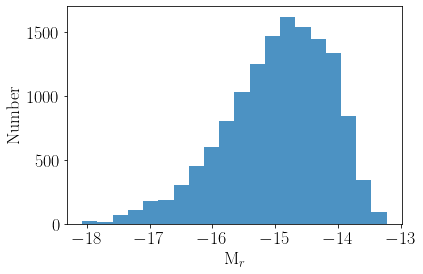

In [16]:
print(min(UDG_kept['UDG abMag']))
print(max(UDG_kept['UDG abMag']))

fig, ax = plt.subplots()
#plt.title('absolute magnitude of UDG satellites', fontsize=15)
plt.xlabel('M$_r$', fontsize=18)
plt.ylabel('Number',fontsize=18)
#abs_hist = plt.hist(UDG_kept['UDG abMag'],bins=20,weights=UDG_kept['weight'])
abs_hist = plt.hist(UDG_keep['UDG abMag'],bins=20,weights=1./UDG_keep['Comp'],alpha=0.8)

print('peak is', np.array(abs_hist[1])[int(np.argmax(abs_hist[0]))])

plt.savefig('figure1.png',format='png',dpi=200,bbox_inches='tight')

In [17]:
sep_all, sep_blue, sep_red = np.array([]),np.array([]),np.array([])
weight_all, weight_blue, weight_red = np.array([]), np.array([]), np.array([])

UDG_kept['color class'] = UDG_kept['RSQ_offset'].apply(lambda x: 'red' if abs(x) <= 0.1 else 'blue')

sep_all = UDG_kept['separation'].tolist()
weight_all = UDG_kept['weight'].tolist()                      
sep_red = UDG_kept[UDG_kept['color class']=='red']['separation'].tolist()
weight_red = UDG_kept[UDG_kept['color class']=='red']['weight'].tolist()
sep_blue = UDG_kept[UDG_kept['color class']=='blue']['separation'].tolist()
weight_blue = UDG_kept[UDG_kept['color class']=='blue']['weight'].tolist()

sep_all_dim = UDG_kept[UDG_kept['UDG abMag']>udg_mag_cutoff]['separation'].tolist()
sep_blue_dim = UDG_kept[(UDG_kept['color class']=='blue')&(UDG_kept['UDG abMag']>udg_mag_cutoff)]['separation'].tolist()
sep_red_dim = UDG_kept[(UDG_kept['color class']=='red')&(UDG_kept['UDG abMag']>udg_mag_cutoff)]['separation'].tolist()
weight_all_dim = UDG_kept[UDG_kept['UDG abMag']>udg_mag_cutoff]['weight'].tolist()
weight_blue_dim = UDG_kept[(UDG_kept['color class']=='blue')&(UDG_kept['UDG abMag']>udg_mag_cutoff)]['weight'].tolist()
weight_red_dim = UDG_kept[(UDG_kept['color class']=='red')&(UDG_kept['UDG abMag']>udg_mag_cutoff)]['weight'].tolist()

sep_all_bright = UDG_kept[UDG_kept['UDG abMag']<udg_mag_cutoff]['separation'].tolist()
sep_blue_bright =UDG_kept[(UDG_kept['color class']=='blue')&(UDG_kept['UDG abMag']<udg_mag_cutoff)]['separation'].tolist()
sep_red_bright=UDG_kept[(UDG_kept['color class']=='red')&(UDG_kept['UDG abMag']<udg_mag_cutoff)]['separation'].tolist()
weight_all_bright = UDG_kept[UDG_kept['UDG abMag']<udg_mag_cutoff]['weight'].tolist()
weight_blue_bright = UDG_kept[(UDG_kept['color class']=='blue')&(UDG_kept['UDG abMag']<udg_mag_cutoff)]['weight'].tolist()
weight_red_bright = UDG_kept[(UDG_kept['color class']=='red')&(UDG_kept['UDG abMag']<udg_mag_cutoff)]['weight'].tolist()

sep_bin = UDG_kept[(UDG_kept['UDG abMag']>udg_mag_upper)&(UDG_kept['UDG abMag']<udg_mag_lower)]['separation'].tolist()
sep_blue_bin =UDG_kept[(UDG_kept['color class']=='blue')&(UDG_kept['UDG abMag']>udg_mag_upper)&(UDG_kept['UDG abMag']<udg_mag_lower)]['separation'].tolist()
sep_red_bin=UDG_kept[(UDG_kept['color class']=='red')&(UDG_kept['UDG abMag']>udg_mag_upper)&(UDG_kept['UDG abMag']<udg_mag_lower)]['separation'].tolist()
weight_bin = UDG_kept[(UDG_kept['UDG abMag']>udg_mag_upper)&(UDG_kept['UDG abMag']<udg_mag_lower)]['weight'].tolist()
weight_blue_bin = UDG_kept[(UDG_kept['color class']=='blue')&(UDG_kept['UDG abMag']>udg_mag_upper)&(UDG_kept['UDG abMag']<udg_mag_lower)]['weight'].tolist()
weight_red_bin = UDG_kept[(UDG_kept['color class']=='red')&(UDG_kept['UDG abMag']>udg_mag_upper)&(UDG_kept['UDG abMag']<udg_mag_lower)]['weight'].tolist()


In [18]:
print(len(sep_all), len(sep_all_dim), len(sep_all_bright)) # dim + bright should equal to the total
print(udg_mag_cutoff)

626560 323395 303165
-15.0


In [19]:
def UDG_weighted(UDG_sample):
    # calculate weighted number of UDGs

    all_number, all_blue, all_red = 0, 0, 0 # Initialize the counters
    all_udg, red_udg, blue_udg = np.array([]), np.array([]), np.array([])
    
    for i in range(len(UDG_sample)):
        all_number += UDG_sample['weight'].iloc[i]
    # Weighs the separations using the completion rate
#        print(UDG_kept['color class'].iloc[i])
        if UDG_sample['color class'].iloc[i] == 'blue':
            all_blue +=  UDG_sample['weight'].iloc[i]
            blue_udg = np.append(blue_udg, UDG_sample['color'].iloc[i])
        elif UDG_sample['color class'].iloc[i] == 'red':
            all_red +=  UDG_sample['weight'].iloc[i]
            red_udg = np.append(red_udg, UDG_sample['color'].iloc[i])
    len_udg = len(UDG_sample)
    len_udg_red = len(red_udg)
    len_udg_blue = len(blue_udg)
    #print("Weighted numbers: ", all_number,all_blue,all_red) 
    print("Weighted numbers: ", all_number, 'UDGs total;' , all_red, 'red UDGs and', all_blue, 'blue UDGs') 
    print("Unweighted numbers: ", len_udg, 'UDGs total;' , len_udg_red, 'red UDGs and', len_udg_blue, 'blue UDGs') 
    return all_number, all_blue, all_red, len_udg, len_udg_red, len_udg_blue

In [20]:
all_number, all_blue, all_red, len_udg, len_udg_red, len_udg_blue = UDG_weighted(UDG_kept)
UDG_dim=pd.DataFrame(UDG_kept[UDG_kept['UDG abMag']>udg_mag_cutoff])
all_number_dim, all_blue_dim, all_red_dim, len_udg_dim, len_udg_red_dim, len_udg_blue_dim = UDG_weighted(UDG_dim)
UDG_bright=pd.DataFrame(UDG_kept[UDG_kept['UDG abMag']<udg_mag_cutoff])
all_number_bright, all_blue_bright, all_red_bright, len_udg_bright, len_udg_red_bright, len_udg_blue_bright = UDG_weighted(UDG_bright)
UDG_bin = pd.DataFrame(UDG_kept[(UDG_kept['UDG abMag']>udg_mag_upper)&(UDG_kept['UDG abMag']<udg_mag_lower)])
all_bin, all_bin_blue, all_bin_red, len_bin, len_bin_red, len_bin_blue = UDG_weighted(UDG_bin)

Weighted numbers:  1431434.8954349728 UDGs total; 847900.4829471518 red UDGs and 583534.4124877949 blue UDGs
Unweighted numbers:  626560 UDGs total; 342034 red UDGs and 284526 blue UDGs
Weighted numbers:  845638.4255429278 UDGs total; 555227.4924322492 red UDGs and 290410.93311073666 blue UDGs
Unweighted numbers:  323395 UDGs total; 198912 red UDGs and 124483 blue UDGs
Weighted numbers:  585796.4698919081 UDGs total; 292672.9905148884 red UDGs and 293123.4793770485 blue UDGs
Unweighted numbers:  303165 UDGs total; 143122 red UDGs and 160043 blue UDGs
Weighted numbers:  234644.0592291798 UDGs total; 112015.46105899126 red UDGs and 122628.59817020311 blue UDGs
Unweighted numbers:  125580 UDGs total; 57740 red UDGs and 67840 blue UDGs


In [21]:
print(len(sep_red),'matches (normal galaxies) to red UDGs;', len(sep_blue), 'matches to blue UDGs;',len(sep_all),'total matches')
print(len(sep_red_dim),'matches (normal galaxies) to red dim UDGs;', len(sep_blue_dim), 'matches to blue dim UDGs;',len(sep_all_dim),'total matches')
print(len(sep_red_bright),'matches (normal galaxies) to red bright UDGs;', len(sep_blue_bright), 'matches to blue bright UDGs;',len(sep_all_bright),'total matches')

342034 matches (normal galaxies) to red UDGs; 284526 matches to blue UDGs; 626560 total matches
198912 matches (normal galaxies) to red dim UDGs; 124483 matches to blue dim UDGs; 323395 total matches
143122 matches (normal galaxies) to red bright UDGs; 160043 matches to blue bright UDGs; 303165 total matches


In [22]:
#bins = int(bin_norm*(sz-min_sep)/(1-min_sep))
bins = int(bin_norm*(10-min_sep)/(1-min_sep))


In [23]:
def separation_hist(sep_all, sep_red, sep_blue, weight_all, weight_red, weight_blue, bins):
    # Creates a weighted histogram of separation
    fig, ax = plt.subplots(1, 3, figsize=(35, 6))
    ax[0].set_title('separation for all UDGs', fontsize=15)
    ax[0].set_xlabel(xlabel='log(separation in Mpc)', fontsize=15)
    ax[0].tick_params(axis='x', labelsize=15) 
    ax[0].tick_params(axis='y', labelsize=15) 

    ax[1].set_title('separation for red UDGs', fontsize=15)
    ax[1].set_xlabel(xlabel='log(separation in Mpc)', fontsize=15)
    ax[1].tick_params(axis='x', labelsize=15) 
    ax[1].tick_params(axis='y', labelsize=15)

    ax[2].set_title('separation for blue UDGs', fontsize=15)
    ax[2].set_xlabel(xlabel='log(separation in Mpc)', fontsize=15)
    ax[2].tick_params(axis='x', labelsize=15) 
    ax[2].tick_params(axis='y', labelsize=15)

    # lets make bins be the same width regardless of which file is used (normalized to 5 bins for result_hina_1.csv
    # 5 bins for sz = 1

    allhist = ax[0].hist(sep_all, bins, density=False, weights = weight_all)

    redhist = ax[1].hist(sep_red, allhist[1], density=False, weights = weight_red)
    bluehist = ax[2].hist(sep_blue, allhist[1], density=False, weights = weight_blue)
    
    allhist_un = ax[0].hist(sep_all, allhist[1], density=False)
    redhist_un = ax[1].hist(sep_red, allhist[1], density=False)
    bluehist_un = ax[2].hist(sep_blue, allhist[1], density=False)

    ax[0].set_xscale('log') # changes the scale to log
    ax[1].set_xscale('log') # changes the scale to log
    ax[2].set_xscale('log') # changes the scale to log

    plt.show
    return allhist, redhist, bluehist, allhist_un, redhist_un, bluehist_un, allhist

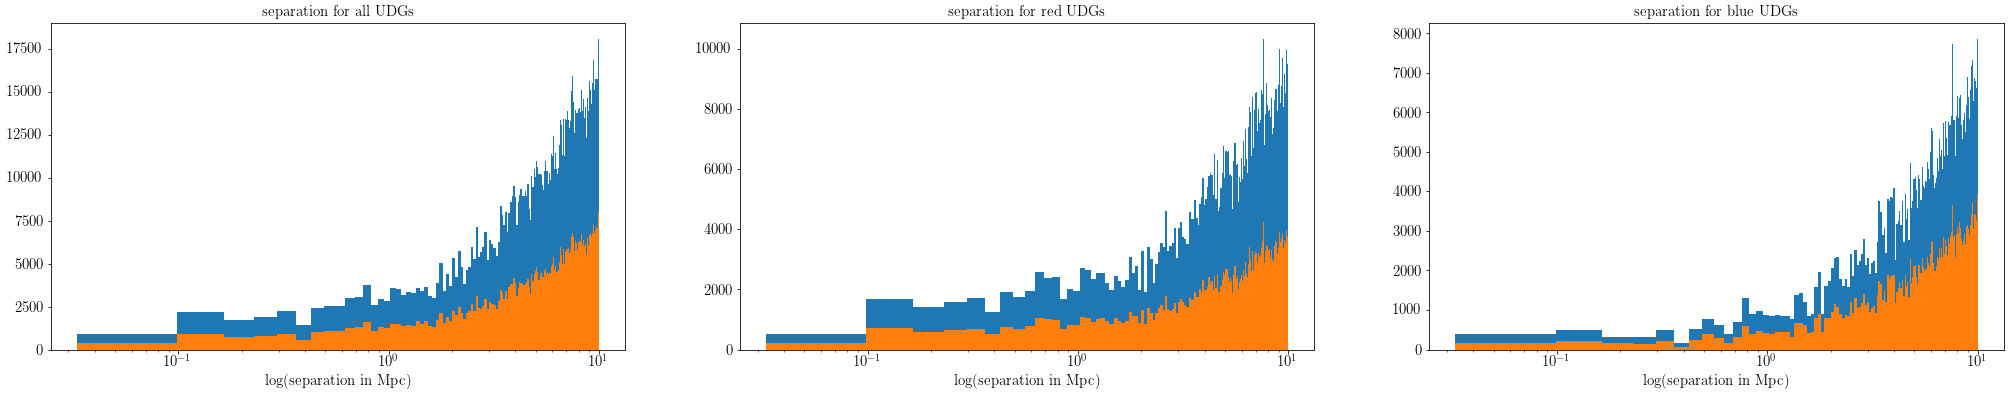

In [24]:
# ALL UDGS 
allhist, redhist, bluehist, allhist_un, redhist_un, bluehist_un, allhist_stan = separation_hist(sep_all, sep_red, sep_blue, weight_all, weight_red, weight_blue, bins)


[0.0329365  0.09850901 0.16408153 0.22965404 0.29522655 0.36079907
 0.42637158 0.49194409 0.55751661 0.62308912 0.68866163 0.75423415
 0.81980666 0.88537917 0.95095169 1.0165242  1.08209671 1.14766923
 1.21324174 1.27881425 1.34438677 1.40995928 1.47553179 1.54110431
 1.60667682 1.67224933 1.73782185 1.80339436 1.86896687 1.93453939
 2.0001119  2.06568441 2.13125693 2.19682944 2.26240195 2.32797447
 2.39354698 2.45911949 2.52469201 2.59026452 2.65583703 2.72140955
 2.78698206 2.85255457 2.91812708 2.9836996  3.04927211 3.11484462
 3.18041714 3.24598965 3.31156216 3.37713468 3.44270719 3.5082797
 3.57385222 3.63942473 3.70499724 3.77056976 3.83614227 3.90171478
 3.9672873  4.03285981 4.09843232 4.16400484 4.22957735 4.29514986
 4.36072238 4.42629489 4.4918674  4.55743992 4.62301243 4.68858494
 4.75415746 4.81972997 4.88530248 4.950875   5.01644751 5.08202002
 5.14759254 5.21316505 5.27873756 5.34431008 5.40988259 5.4754551
 5.54102762 5.60660013 5.67217264 5.73774516 5.80331767 5.868890

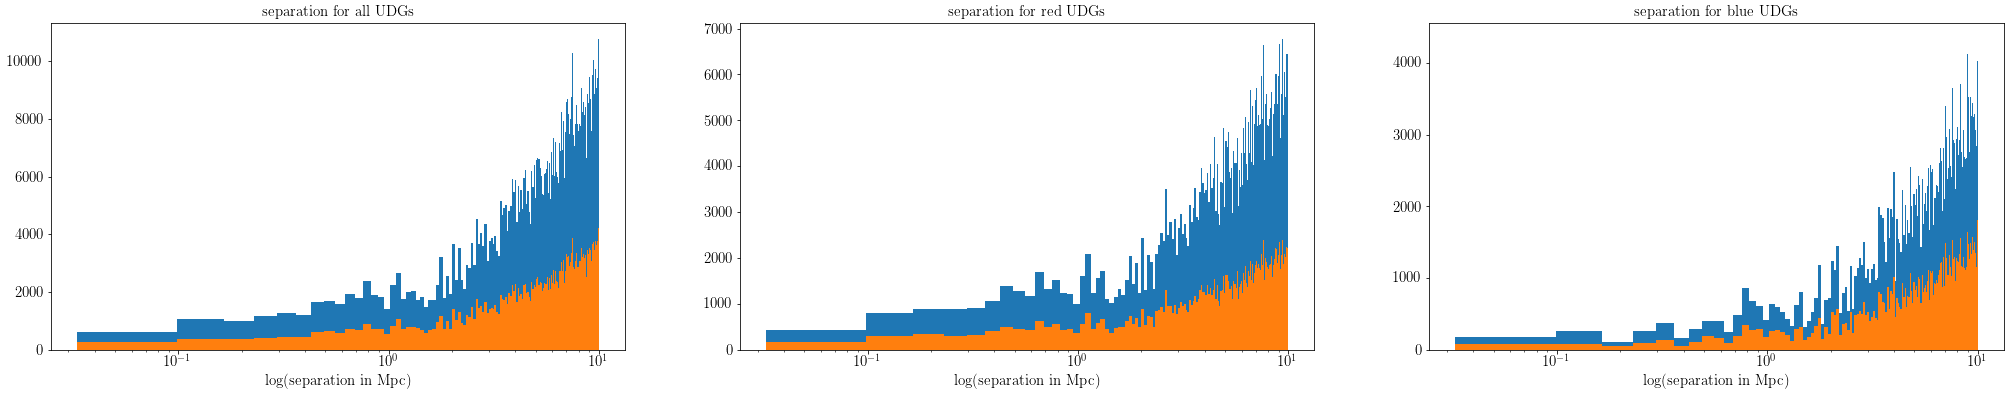

In [25]:
# DIM UDGS
print(allhist_stan[1])
allhist_dim, redhist_dim, bluehist_dim, allhist_un_dim, redhist_un_dim, bluehist_un_dim, allhist_stan_dim = separation_hist(sep_all_dim, sep_red_dim, sep_blue_dim, weight_all_dim, weight_red_dim, weight_blue_dim, allhist_stan[1])


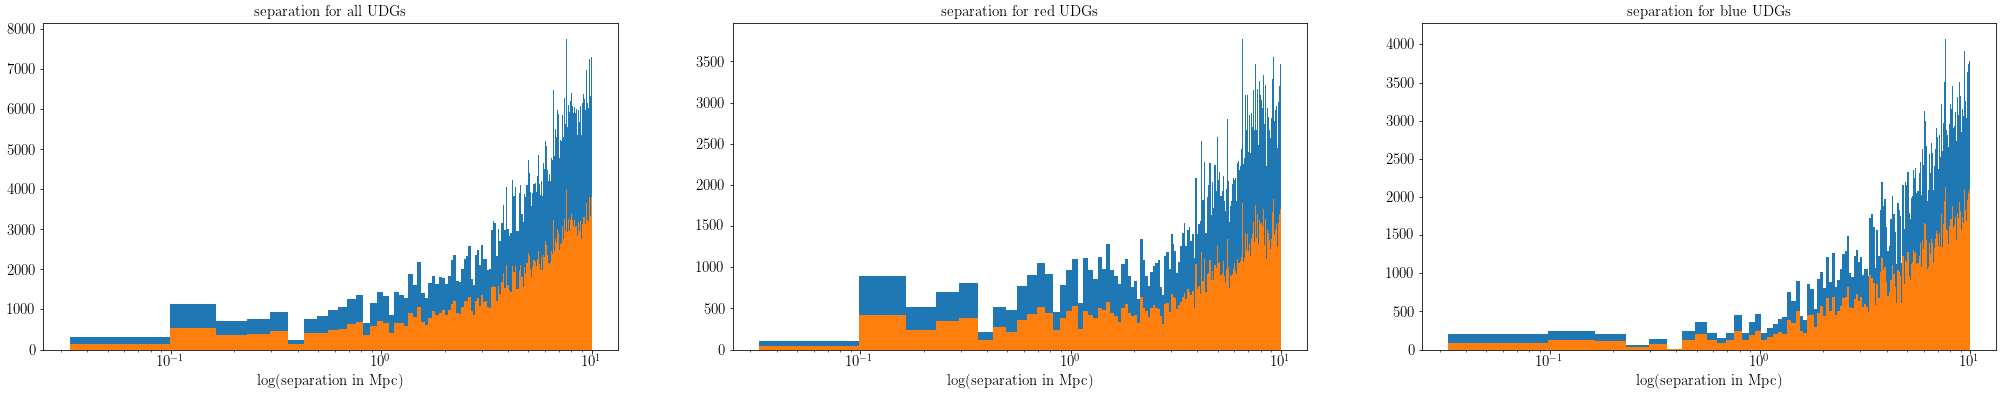

In [26]:
# BRIGHT UDGS
allhist_bright, redhist_bright, bluehist_bright, allhist_un_bright, redhist_un_bright, bluehist_un_bright, allhist_stan_bright = separation_hist(sep_all_bright, sep_red_bright, sep_blue_bright, weight_all_bright, weight_red_bright, weight_blue_bright, allhist_stan[1])


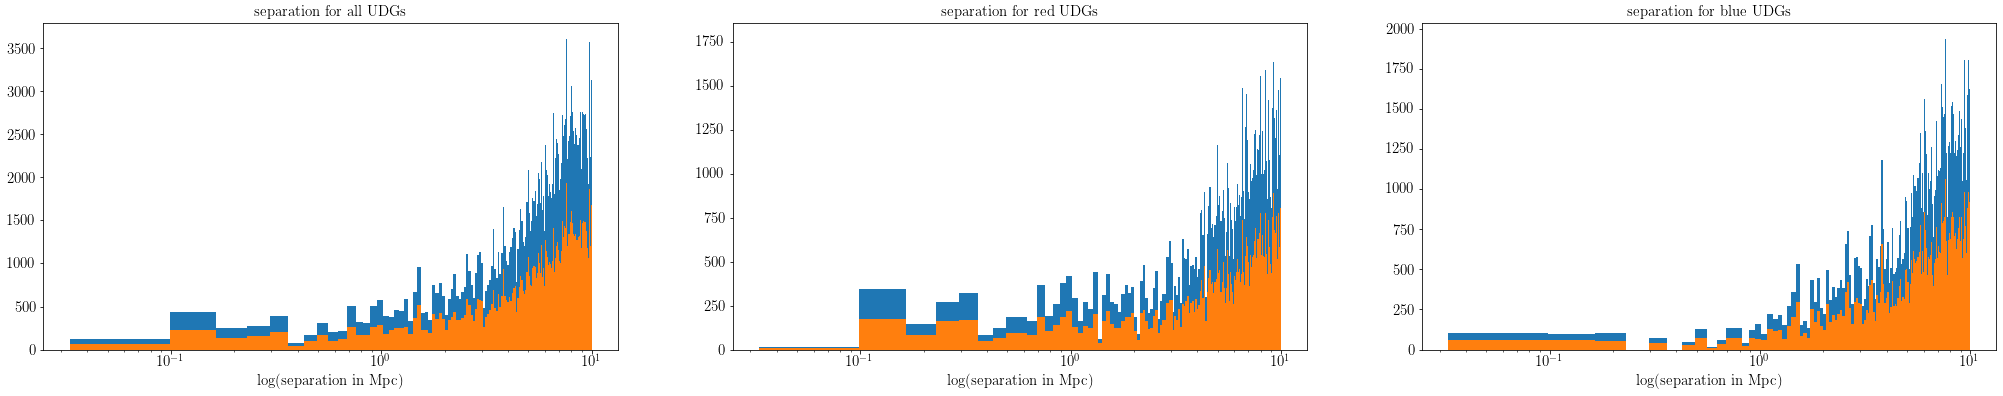

In [27]:
# UDGs in BIN
allhist_bin, red_bin, blue_bin, allhist_un_bin, red_un_bin, blue_un_bin, allhist_stan_bin = separation_hist(sep_bin, sep_red_bin, sep_blue_bin, weight_bin, weight_red_bin, weight_blue_bin, allhist_stan[1])


In [28]:
def annulus(allhist, bins):
    # Below is used to calculate areas of annuli 
    # Skip to the next cell for log scaling
    area_annulus = np.array([])
    # Calculates the area of annulus (= pi*(R^2-r^2))
    a = np.array([])
    # NEW
    for i in range(0, bins):
    # in case of Kpc, radius would be 100, 200, 300,..., 1500 kpc
        R = allhist[1][i+1] # R = outer radius
        r = allhist[1][i] # r = inner radius 
        # calculate area of annulus and convert to Mpc^-2
        area = np.pi*(R**2 - r**2) 
        area_annulus = np.append(area_annulus, area)
        a = np.append(a, (allhist[1][i] + allhist[1][i+1])/2.)
    return a, area_annulus

In [29]:
a, area_annulus = annulus(allhist, bins)
a_dim, area_annulus_dim = annulus(allhist_dim, bins)
a_bright, area_annulus_bright = annulus(allhist_bright, bins)
a_bin, area_annulus_bin = annulus(allhist_bin, bins)


In [30]:
def hist_error(allhist, redhist, bluehist, allhist_un, redhist_un, bluehist_un):
    # --- Calculate/define uncertainty below ---
    # uncertainty = sqrt(n); Poisson 
    # Arrays below are the values +/- uncertainty
    # needs to be sqrt of the original (unweighted) counts that are then scaled up by weighting
    
    all_err=[]
    red_err=[]
    blue_err=[]

    for i in range(len(allhist[0])):
        if (allhist[0][i]>0):
            all_err = np.append(all_err,unp.uarray(allhist[0][i], np.sqrt(allhist_un[0][i])*allhist[0][i]/allhist_un[0][i]))
        else:
            all_err = np.append(all_err,unp.uarray(0.0, 1.0))
        if (redhist[0][i]>0):
            red_err = np.append(red_err,unp.uarray(redhist[0][i], np.sqrt(redhist_un[0][i])*redhist[0][i]/redhist_un[0][i]))
        else:
            red_err = np.append(red_err,unp.uarray(0.0, 1.0))
        if (bluehist[0][i]>0):
            blue_err = np.append(blue_err,unp.uarray(bluehist[0][i], np.sqrt(bluehist_un[0][i])*bluehist[0][i]/bluehist_un[0][i]))
        else:
            blue_err = np.append(blue_err,unp.uarray(0.0, 1.0))
        
    return all_err, red_err, blue_err

In [31]:
all_err, red_err, blue_err =  hist_error(allhist, redhist, bluehist, allhist_un, redhist_un, bluehist_un)
all_err_dim, red_err_dim, blue_err_dim =  hist_error(allhist_dim, redhist_dim, bluehist_dim, allhist_un_dim, redhist_un_dim, bluehist_un_dim)
all_err_bright, red_err_bright, blue_err_bright =  hist_error(allhist_bright, redhist_bright, bluehist_bright, allhist_un_bright, redhist_un_bright, bluehist_un_bright)
all_err_bin, red_err_bin, blue_err_bin =  hist_error(allhist_bin, red_bin, blue_bin, allhist_un_bin, red_un_bin, blue_un_bin)


In [32]:
def density(all_err, red_err, blue_err, all_number, all_red, all_blue, a, bins, area_annulus):
    # Calculates density of UDGs
    density_all, density_red, density_blue = np.array([]), np.array([]), np.array([])
    for i in range(0, bins):
        density_a = all_err[i]/area_annulus[i]
        density_r = red_err[i]/area_annulus[i]
        density_b = blue_err[i]/area_annulus[i]
              
    # Appends densities of UDGs to the new arrays     
        density_all = np.append(density_all, density_a)
        density_red = np.append(density_red, density_r)
        density_blue = np.append(density_blue, density_b)
    
    x_prime = a
    
    x_prime = x_prime[(density_red>0) & (density_blue>0)]
    density_all = density_all[(density_red>0) & (density_blue>0)]
    density_red1 = density_red[(density_red>0) & (density_blue>0)]
    density_blue = density_blue[(density_red>0) & (density_blue>0)]
    density_red = density_red1
    
    y_prime = unp.log10(density_all/UDG_num)
    y_r = unp.log(density_red/UDG_num_red)
    y_b = unp.log10(density_blue/UDG_num_blue)
    
    y_prime_lin = (density_all/UDG_num)
    y_r_lin = (density_red/UDG_num_red)
    y_b_lin = (density_blue/UDG_num_blue)
    
    return x_prime, y_prime, y_r, y_b, y_prime_lin, y_r_lin, y_b_lin

In [33]:
x_prime, y_prime, y_r, y_b, y_prime_lin, y_r_lin, y_b_lin = density(all_err, red_err, blue_err, all_number, all_red, all_blue, a, bins, area_annulus)
x_prime_dim, y_prime_dim, y_r_dim, y_b_dim, y_prime_lin_dim, y_r_lin_dim, y_b_lin_dim = density(all_err_dim, red_err_dim, blue_err_dim, all_number_dim, all_red_dim, all_blue_dim, a_dim, bins, area_annulus_dim)
x_prime_bright, y_prime_bright, y_r_bright, y_b_bright, y_prime_lin_bright, y_r_lin_bright, y_b_lin_bright = density(all_err_bright, red_err_bright, blue_err_bright, all_number_bright, all_red_bright, all_blue_bright, a_bright, bins, area_annulus_bright)
x_prime_bin, y_prime_bin, y_r_bin, y_b_bin, y_prime_lin_bin, y_r_lin_bin, y_b_lin_bin = density(all_err_bin, all_err_bin, all_err_bin, all_bin, all_bin, all_bin, a_bin, bins, area_annulus_bin)


In [34]:
def value_error(y_prime, y_r, y_b, y_prime_lin, y_r_lin, y_b_lin):
    # Creates separate arrays for values and uncertainties for plotting;
    # Abbreviations:
    # lin = linear scale
    # val = actual value, err = error(uncertainty)
    # r = red and b = blue

    # Defines arrays below
    y_prime_val, y_prime_err = [],[]
    y_r_val, y_r_err = [], []
    y_b_val, y_b_err = [], []
    y_prime_lin_val, y_prime_lin_err = [], []
    y_r_lin_val, y_r_lin_err = [], []
    y_b_lin_val, y_b_lin_err = [], []

    for i in range(len(y_prime)):
    # Separates y_prime_lin
        y_prime_val.append(y_prime[i].n) # Value
        y_prime_err.append(y_prime[i].s) # Uncertainty
    # Separates y_r 
        y_r_val.append(y_r[i].n)
        y_r_err.append(y_r[i].s) 
    # Separates y_b
        y_b_val.append(y_b[i].n)
        y_b_err.append(y_b[i].s)
    # Separates y_prime_lin
        y_prime_lin_val.append(y_prime_lin[i].n)
        y_prime_lin_err.append(y_prime_lin[i].s)
    # Separates y_r_lin
        y_r_lin_val.append(y_r_lin[i].n)
        y_r_lin_err.append(y_r_lin[i].s)
    # Separates y_b_lin
        y_b_lin_val.append(y_b_lin[i].n)
        y_b_lin_err.append(y_b_lin[i].s)
        
    return y_prime_val, y_prime_err, y_r_val, y_r_err, y_b_val, y_b_err, y_prime_lin_val, y_prime_lin_err, y_r_lin_val, y_r_lin_err, y_b_lin_val, y_b_lin_err,

In [35]:
y_prime_val, y_prime_err, y_r_val, y_r_err, y_b_val, y_b_err, y_prime_lin_val, y_prime_lin_err, y_r_lin_val, y_r_lin_err, y_b_lin_val, y_b_lin_err, = value_error(y_prime, y_r, y_b, y_prime_lin, y_r_lin, y_b_lin)
y_prime_val_dim, y_prime_err_dim, y_r_val_dim, y_r_err_dim, y_b_val_dim, y_b_err_dim, y_prime_lin_val_dim, y_prime_lin_err_dim, y_r_lin_val_dim, y_r_lin_err_dim, y_b_lin_val_dim, y_b_lin_err_dim, = value_error(y_prime_dim, y_r_dim, y_b_dim, y_prime_lin_dim, y_r_lin_dim, y_b_lin_dim)
y_prime_val_bright, y_prime_err_bright, y_r_val_bright, y_r_err_bright, y_b_val_bright, y_b_err_bright, y_prime_lin_val_bright, y_prime_lin_err_bright, y_r_lin_val_bright, y_r_lin_err_bright, y_b_lin_val_bright, y_b_lin_err_bright, = value_error(y_prime_bright, y_r_bright, y_b_bright, y_prime_lin_bright, y_r_lin_bright, y_b_lin_bright)
y_prime_val_bin, y_prime_err_bin, y_r_val_bin, y_r_err_bin, y_b_val_bin, y_b_err_bin, y_prime_lin_val_bin, y_prime_lin_err_bin, y_r_lin_val_bin, y_r_lin_err_bin, y_b_lin_val_bin, y_b_lin_err_bin, = value_error(y_prime_bin, y_r_bin, y_b_bin, y_prime_lin_bin, y_r_lin_bin, y_b_lin_bin)


In [36]:
# Defines power law
def power_all(x, a, k, b):
    return a*(x**k) + b

# Defines power law function for fitting
def power_no_back(x, a, k):
    return 2*np.pi*a*(x**k)*x 

# Defines function for fitting for background
def background(x, b):
    return 2*np.pi*b*x

In [37]:
z = (max_z + min_z)/2 # avg redshift
deg = np.sqrt(survey_area)*u.deg
Area_survey = (deg/u.deg/206265*3600*cosmo.angular_diameter_distance(z)/u.Mpc)**2 # Finds the survey area
plim = sz/206265*3600*cosmo.angular_diameter_distance(z)
print('Input sz corresponds to ',plim,' Mpc at the mean redshift')
plim = sz/206265*3600*cosmo.angular_diameter_distance(min_z)
print('Input sz corresponds to ',plim,' Mpc at the min redshift')


Input sz corresponds to  12.329471913329648 Mpc  Mpc at the mean redshift
Input sz corresponds to  11.11877130219394 Mpc  Mpc at the min redshift


In [38]:
from matplotlib import rc
# Import LaTeX
rc('font',**{'family':'serif','serif':['Times']})
rc('text',usetex=True)

In [39]:
# Defines a function that finds the nearest values at sigma
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx #, array[idx]

In [40]:
def surf_plot(x_prime, y_prime_lin_val, y_prime_lin_err, y_r_lin_val, y_r_lin_err, y_b_lin_val, y_b_lin_err):
    # Creates the plot of surface density 

    import matplotlib.ticker as mticker
    from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter
    from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,mark_inset)
    plt.rc('axes.formatter',useoffset=False)
    
    fig, ax = plt.subplots(2,figsize=(6, 8))

    ax[0].text(-0.5,-2.7,'Pair Surface Density ({N$_{UDG}$}$^{-1}$ Mpc$^{-2}$)',rotation=90,fontsize=18)
    ax[0].set_xlim(0.02, 2)
    ax[0].set_ylim(0.2, 4.2)

    ax[0].errorbar(x_prime, y_prime_lin_val, yerr=y_prime_lin_err, color='steelblue',fmt='o',alpha = 0.8)
    popt_power_all, pcov_power_all = scipy.optimize.curve_fit(power_all, x_prime, y_prime_lin_val, sigma=y_prime_lin_err, p0=[0.5,-1.0,0.1], bounds=[(0,-3,0.0), (1,1,1)],maxfev=1000000)

    ax[0].plot(x_prime, power_all(x_prime, *popt_power_all), color='steelblue',linestyle='dashed')
    print('all UDGs constants: ', popt_power_all)
    print("a =", popt_power_all[0], "+/-", pcov_power_all[0,0]**0.5, "\nk =", popt_power_all[1], "+/-", pcov_power_all[1,1]**0.5, "\nb =", popt_power_all[2], "+/-", pcov_power_all[2,2]**0.5)

# Create an inset axis in the top right corner
    axin = ax[0].inset_axes([0.4, 0.4, 0.5, 0.5])
    axin.set_xlim(0.02, 0.4)
    axin.set_ylim(0.02, 4.2)
    axin.errorbar(x_prime, y_prime_lin_val, yerr=y_prime_lin_err, color='steelblue',fmt='o',alpha = 0.8)
    axin.plot(x_prime, power_all(x_prime, *popt_power_all), color='steelblue',linestyle='dashed')

    
    popt_power_red, pcov_power_red = scipy.optimize.curve_fit(power_all, x_prime, y_r_lin_val, sigma=y_r_lin_err, p0=[0.5,-1.0,0.1], bounds=[(0,-3,0.0), (1,1,1)],maxfev=1000000)

    print('red UDGs constants: ', popt_power_red)
    print("a =", popt_power_red[0], "+/-", pcov_power_red[0,0]**0.5, "\nk =", popt_power_red[1], "+/-", pcov_power_red[1,1]**0.5, "\nb =", popt_power_red[2], "+/-", pcov_power_red[2,2]**0.5)

    popt_power_blue, pcov_power_blue = scipy.optimize.curve_fit(power_all, x_prime, y_b_lin_val, sigma=y_b_lin_err, p0=[0.5,-1.0,0.1], bounds=[(0.0,-3,0.0), (1.,1,1)], maxfev=1000000)
    print('blue UDGs constants: ', popt_power_blue)
    print("a =", popt_power_blue[0], "+/-", pcov_power_blue[0,0]**0.5, "\nk =", popt_power_blue[1], "+/-", pcov_power_blue[1,1]**0.5, "\nb =", popt_power_blue[2], "+/-", pcov_power_blue[2,2]**0.5)


    N1_all = scipy.integrate.quad(power_no_back,min_sep,r_out,args=(popt_power_all[0], popt_power_all[1])) #integrate from min_sep to 0.2 Mpc
    N2_all = scipy.integrate.quad(background,min_sep,r_out,args=(popt_power_all[2]))
    print("N1 =", N1_all[0], ", N2 =", N2_all[0],  ", N1/N2 =", N1_all[0]/N2_all[0])
    print(N1_all[0]*all_number/((Area_survey) * popt_power_all[2]))

    N1_red = scipy.integrate.quad(power_no_back,min_sep,r_out,args=(popt_power_red[0], popt_power_red[1]))
    N2_red = scipy.integrate.quad(background,min_sep,r_out,args=(popt_power_red[2]))
    print("N1 =", N1_red[0],", N2 =", N2_red[0], ", N1/N2 =", N1_red[0]/N2_red[0])
    print(N1_red[0]*all_red/((Area_survey) * popt_power_all[2]))

    N1_blue = scipy.integrate.quad(power_no_back,min_sep,r_out,args=(popt_power_blue[0], popt_power_blue[1]))
    N2_blue = scipy.integrate.quad(background,min_sep,r_out,args=(popt_power_blue[2]))
    print("N1 =", N1_blue[0], ", N2 =", N2_blue[0], ", N1/N2 =", N1_blue[0]/N2_blue[0])
    print(N1_blue[0]*all_blue/((Area_survey) * popt_power_all[2]))

#    xp_log = np.log10(x_prime)
    p0 = [0.5,-1.0,.1]

    popt_power_all, pcov_power_all = scipy.optimize.curve_fit(power_all, x_prime, y_prime_lin_val, sigma=y_prime_lin_err, p0=p0, bounds=[(0,-3,0), (1,1,1)])

#    fig, ax = plt.subplots()

    ax[1].set_xlabel('Radius [Mpc]',fontsize=18)
    ax[1].set_xlim(0.02, 10)
    ax[1].set_ylim(0.2, 4.2)
    
    ax[1].errorbar(x_prime, y_prime_lin_val, yerr=y_prime_lin_err, color='steelblue',fmt='o',alpha=0.8)
    ax[1].plot(x_prime, power_all(x_prime, *popt_power_all), color='steelblue',linestyle='dashed')

    ax[1].set_xscale('log')
    ax[1].set_yscale('log')

    ax[1].xaxis.set_major_formatter(mticker.ScalarFormatter())
    ax[1].xaxis.set_major_formatter(StrMethodFormatter('{x:.1f}'))
    ax[1].yaxis.set_major_formatter(StrMethodFormatter('{x:.1f}'))

#    ax[1].xaxis.get_major_formatter().set_scientific(False)
    ax[1].yaxis.set_major_formatter(mticker.ScalarFormatter())
#    ax[1].yaxis.get_major_formatter().set_scientific(False)
    ax[1].yaxis.set_ticks(np.arange(0.3, 2.5, 0.6))       
    
    plt.savefig('figure2.png',format='png',dpi=200,bbox_inches='tight')    

    print('all UDGs constants: ', popt_power_all)
    print("a =", popt_power_all[0], "+/-", pcov_power_all[0,0]**0.5, "\nk =", popt_power_all[1], "+/-", pcov_power_all[1,1]**0.5, "\nb =", popt_power_all[2], "+/-", pcov_power_all[2,2]**0.5)

    popt_power_red, pcov_power_red = scipy.optimize.curve_fit(power_all, x_prime, y_r_lin_val, sigma=y_r_lin_err, p0=[0.5,-1.0,0.1], bounds=[(0,-3,0), (1,1,1)])
    print('red UDGs constants: ', popt_power_red)
    print("a =", popt_power_red[0], "+/-", pcov_power_red[0,0]**0.5, "\nk =", popt_power_red[1], "+/-", pcov_power_red[1,1]**0.5, "\nb =", popt_power_red[2], "+/-", pcov_power_red[2,2]**0.5)

    popt_power_blue, pcov_power_blue = scipy.optimize.curve_fit(power_all, x_prime, y_b_lin_val, sigma=y_b_lin_err, p0=p0, bounds=[(0,-3,0), (1,1,1)])
    print('blue UDGs constants: ', popt_power_blue)
    print("a =", popt_power_blue[0], "+/-", pcov_power_blue[0,0]**0.5, "\nk =", popt_power_blue[1], "+/-", pcov_power_blue[1,1]**0.5, "\nb =", popt_power_blue[2], "+/-", pcov_power_blue[2,2]**0.5)
    
    return popt_power_all, pcov_power_all, popt_power_red, pcov_power_red, popt_power_blue, pcov_power_blue

In [41]:
def MC(popt_power_all, popt_power_red, popt_power_blue, all_number, all_blue, all_red):
    # Saves all the fitting parameters (by color) as variables 

    mu_a_all, sigma_a_all = popt_power_all[0], pcov_power_all[0,0]**0.5
    mu_k_all, sigma_k_all = popt_power_all[1], pcov_power_all[1,1]**0.5
    mu_a_red, sigma_a_red = popt_power_red[0], pcov_power_red[0,0]**0.5
    mu_k_red, sigma_k_red = popt_power_red[1], pcov_power_red[1,1]**0.5
    mu_a_blue, sigma_a_blue = popt_power_blue[0], pcov_power_blue[0,0]**0.5
    mu_k_blue, sigma_k_blue = popt_power_blue[1], pcov_power_blue[1,1]**0.5
    s_a_all = np.random.normal(mu_a_all, sigma_a_all, 10000)
    s_b_all = np.random.normal(mu_k_all, sigma_k_all, 10000)
    s_a_red = np.random.normal(mu_a_red, sigma_a_red, 10000)
    s_b_red = np.random.normal(mu_k_red, sigma_k_red, 10000)
    s_a_blue = np.random.normal(mu_a_blue, sigma_a_blue, 10000)
    s_b_blue = np.random.normal(mu_k_blue, sigma_k_blue, 10000)

    integral_all = np.array([])
    # Runs Monte Carlo to integrate the surface density of all UDGs; n = 10000 (iterations) 
    for i in range(0, len(s_a_all)):
        N1_all = scipy.integrate.quad(power_no_back,min_sep,r_out,args=(s_a_all[i], s_b_all[i]))
        N1_value = N1_all[0]*all_number/(Area_survey * popt_power_all[2])
        integral_all = np.append(integral_all, N1_value)    

    integral_red = np.array([])
    # Runs Monte Carlo to integrate the surface density of red UDGs; n = 10000 (iterations) 
    for i in range(0, len(s_a_all)):
        N1_r = scipy.integrate.quad(power_no_back,min_sep,r_out,args=(s_a_red[i], s_b_red[i]))
        N1_red = N1_r[0]*all_red/(Area_survey * popt_power_all[2])
        integral_red = np.append(integral_red, N1_red)
        
    integral_blue = np.array([])
    # Runs Monte Carlo to integrate the surface density of blue UDGs; n = 10000 (iterations) 
    for i in range(0, len(s_a_all)):
        N1_b = scipy.integrate.quad(power_no_back,min_sep,r_out,args=(s_a_blue[i], s_b_blue[i]))
        N1_blue = N1_b[0]*all_blue/(Area_survey * popt_power_all[2])
        integral_blue = np.append(integral_blue, N1_blue)
        
    return integral_all, integral_red, integral_blue

In [42]:
def MC_plot(integral_all, integral_red, integral_blue):
    arr_all, arr_red, arr_blue = np.array([]), np.array([]), np.array([])
    sum_all, sum_red, sum_blue = 0, 0, 0 

    for i in integral_all:
        sum_all += i
        arr_all = np.append(arr_all, sum_all)

    for i in integral_red:
        sum_red += i
        arr_red = np.append(arr_red, sum_red) 

    for i in integral_blue:
        sum_blue += i
        arr_blue = np.append(arr_blue, sum_blue) 
    
    return arr_all, arr_red, arr_blue

In [43]:
lower = .16 # Defines lower percentage; .16 = 16%
middle = .50 # .50 = 50%
upper = .84 # Defines upper percentage; .84 = 84% 

<ipython-input-40-a824a6c140ad>:6: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,mark_inset)


all UDGs constants:  [ 0.27842992 -0.87063642  0.26130059]
a = 0.27842991688344354 +/- 0.021197477045060018 
k = -0.8706364193989028 +/- 0.07201496480431892 
b = 0.26130058708742615 +/- 0.01056115658266889
red UDGs constants:  [ 0.38517514 -0.86278675  0.23229877]
a = 0.3851751404736974 +/- 0.02862173557650849 
k = -0.8627867481924141 +/- 0.07056799292295002 
b = 0.2322987651699572 +/- 0.014230689259809396
blue UDGs constants:  [ 0.06615938 -1.12751041  0.31367391]
a = 0.06615938209452046 +/- 0.02341370849317517 
k = -1.1275104052959504 +/- 0.26287904025112807 
b = 0.3136739058304774 +/- 0.0077159042760768445
N1 = 0.3050041129501344 , N2 = 0.050977890296375845 , N1/N2 = 5.983066603519643
54.9563604852953
N1 = 0.4149881489224189 , N2 = 0.04531984064335653 , N1/N2 = 9.156875731054724
44.29158731070012
N1 = 0.1264492314775115 , N2 = 0.06119555313096835 , N1/N2 = 2.066314054011241
9.288024115592306
all UDGs constants:  [ 0.27842992 -0.87063642  0.26130059]
a = 0.27842991688344354 +/- 0.021

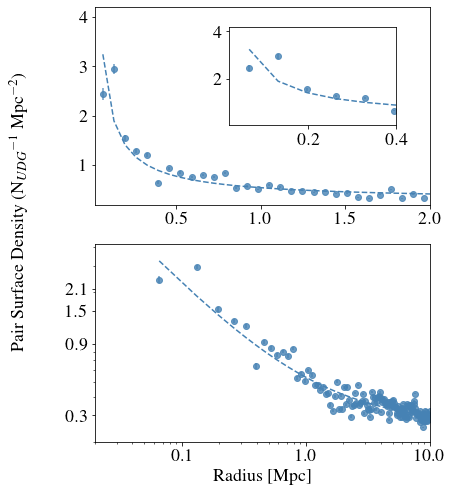

In [44]:
popt_power_all, pcov_power_all, popt_power_red, pcov_power_red, popt_power_blue, pcov_power_blue = surf_plot(x_prime, y_prime_lin_val, y_prime_lin_err, y_r_lin_val, y_r_lin_err, y_b_lin_val, y_b_lin_err)

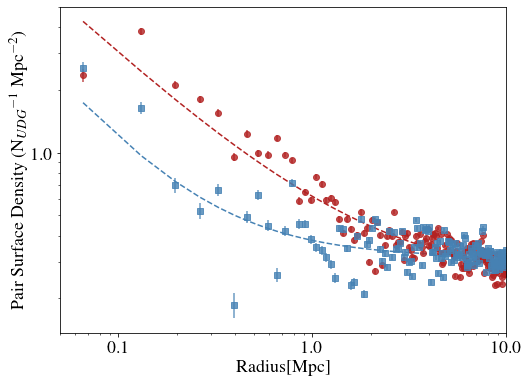

In [45]:
import matplotlib.ticker as mticker
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,mark_inset)
plt.rc('axes.formatter',useoffset=False)
 
fig, axs = plt.subplots(figsize=(8,6))


    
axs.set_xscale('log')
axs.set_yscale('log')

axs.xaxis.set_major_formatter(mticker.ScalarFormatter())
axs.xaxis.set_major_formatter(StrMethodFormatter('{x:.1f}'))
axs.yaxis.set_major_formatter(StrMethodFormatter('{x:.1f}'))

axs.set_ylabel('Pair Surface Density ({N$_{UDG}$}$^{-1}$ Mpc$^{-2}$)',fontsize=18)
axs.set_xlabel('Radius[Mpc]',fontsize=18)
            
axs.set_xlim(0.05, 10)


axs.errorbar(x_prime, y_r_lin_val, yerr=y_r_lin_err, color='firebrick',fmt='o',alpha = 0.8)
axs.errorbar(x_prime, y_b_lin_val, yerr=y_b_lin_err, color='steelblue',fmt='s',alpha = 0.8)

axs.plot(x_prime, power_all(x_prime, *popt_power_blue), color='steelblue',linestyle='dashed')
axs.plot(x_prime, power_all(x_prime, *popt_power_red), color='firebrick',linestyle='dashed')
plt.savefig('figure3.png',format='png',dpi=200,bbox_inches='tight')    



In [46]:
#integral_all, integral_red, integral_blue = MC(popt_power_all, popt_power_red, popt_power_blue, all_number, all_blue, all_red)
integral_all, integral_red, integral_blue = MC(popt_power_all, popt_power_red, popt_power_blue, UDG_num, UDG_num_blue, UDG_num_red)
arr_all, arr_red, arr_blue = MC_plot(integral_all, integral_red, integral_blue)

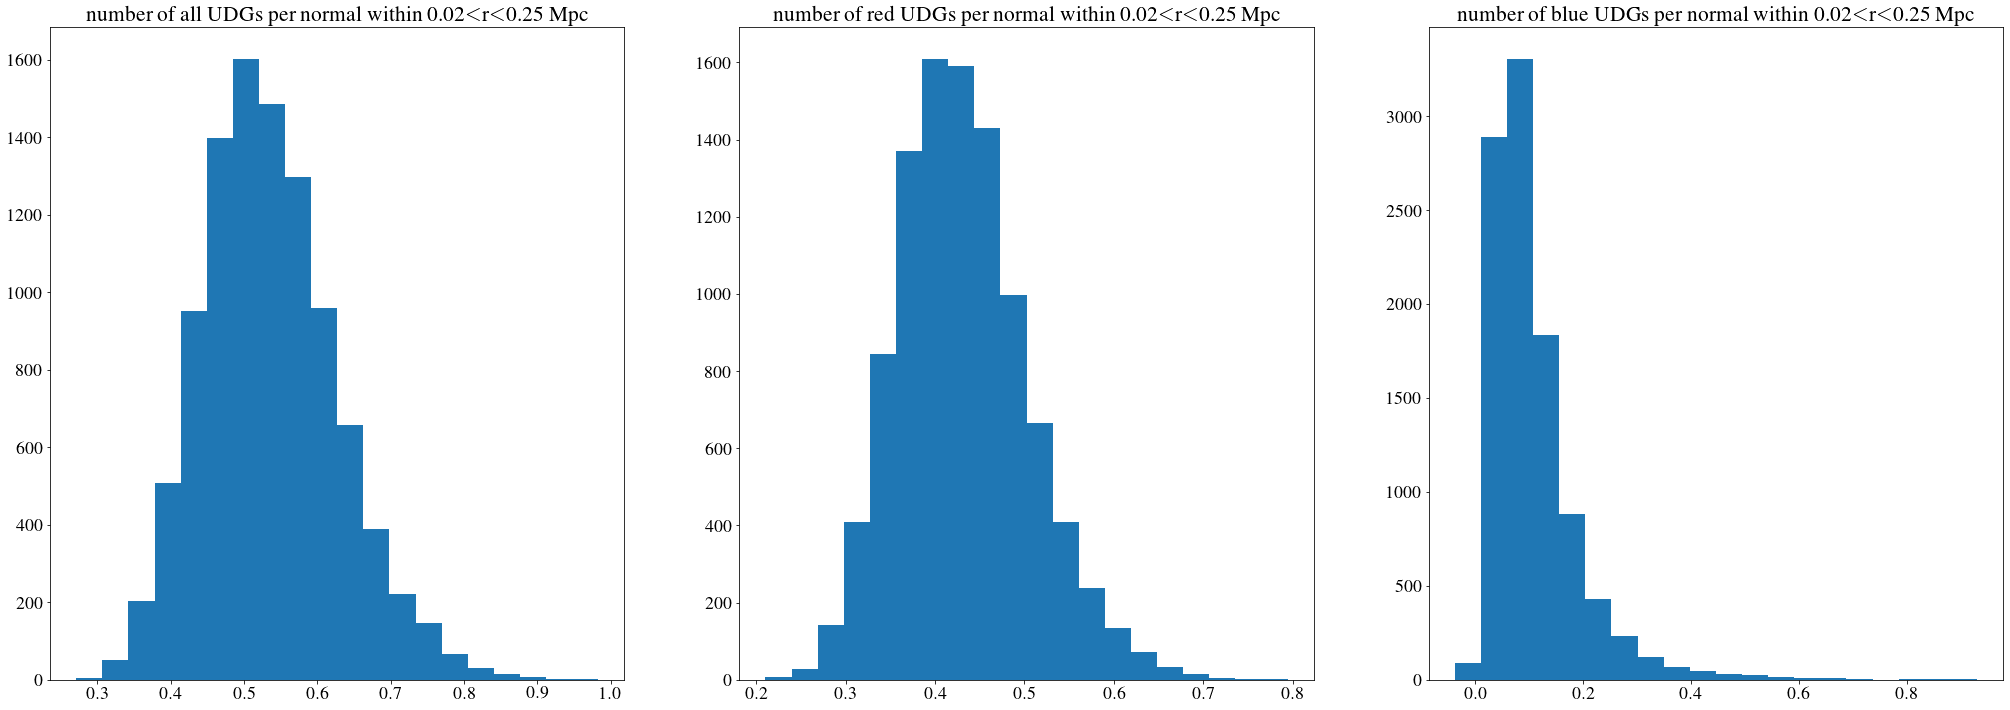

In [47]:
# Creates a histogram that shows the reuslts of Monte Carlo for all UDGs
fig, ax = plt.subplots(1, 3, figsize=(35, 12))
integral_all.sort()
integral_red.sort()
integral_blue.sort()
#fig, ax = plt.subplots()
st1 = 'number of all UDGs per normal within ' + str(min_sep) + '$<$r$<$' + str(r_out) + ' Mpc'
st2 = 'number of red UDGs per normal within ' + str(min_sep) + '$<$r$<$' + str(r_out) + ' Mpc'
st3 = 'number of blue UDGs per normal within ' + str(min_sep) + '$<$r$<$' + str(r_out) + ' Mpc'

ax[0].set_title(st1)
all_hist = ax[0].hist(integral_all.data, bins=20)

ax[1].set_title(st2)
all_hist = ax[1].hist(integral_red.data, bins=20)

ax[2].set_title(st3)
all_hist = ax[2].hist(integral_blue.data, bins=20)

Number of UDGs per normal =  0.53 +  0.10 -  0.08
0.4451226760241862 0.527115695461401 0.6247980062115189
uncertainty: 0.08199301943721482 to 0.0976823107501179
Number of red UDGs per normal =  0.43 +  0.08 -  0.06
0.3608232052144221 0.42527233207970333 0.5018292772674314
uncertainty: 0.0644491268652812 to 0.0765569451877281
Number of blue UDGs per normal =  0.08 +  0.08 -  0.04
0.04144812071116047 0.08395563687552642 0.1661036198491443
uncertainty: 0.04250751616436595 to 0.08214798297361788


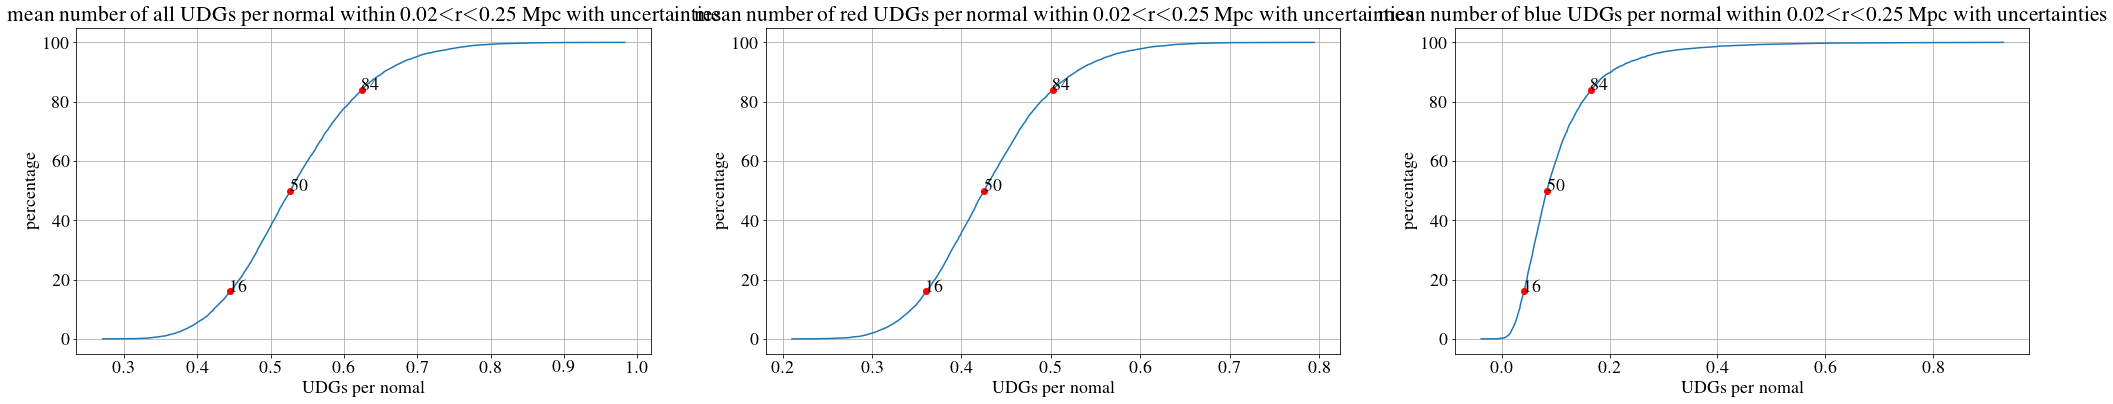

In [48]:
fig, ax = plt.subplots(1, 3, figsize=(35, 6))

st1 = 'mean number of all UDGs per normal within ' + str(min_sep) + '$<$r$<$' + str(r_out) + ' Mpc with uncertainties'
st2 = 'mean number of red UDGs per normal within ' + str(min_sep) + '$<$r$<$' + str(r_out) + ' Mpc with uncertainties'
st3 = 'mean number of blue UDGs per normal within ' + str(min_sep) + '$<$r$<$' + str(r_out) + ' Mpc with uncertainties'


ax[0].set_title(st1)
perc_all = np.array(arr_all/arr_all[-1])
ax[0].plot(integral_all, perc_all * 100)

# 16%
ax[0].plot(integral_all[find_nearest(perc_all, lower)], perc_all[find_nearest(perc_all, lower)] * 100, 'ro')
ax[0].text(integral_all[find_nearest(perc_all, lower)], perc_all[find_nearest(perc_all, lower)] * 100, ' 16%, ' + str('{0:.{1}f}'.format(integral_all[find_nearest(perc_all, lower)], 3)))

# 50%
ax[0].plot(integral_all[find_nearest(perc_all, middle)], perc_all[find_nearest(perc_all, middle)] * 100, 'ro')
ax[0].text(integral_all[find_nearest(perc_all, middle)], perc_all[find_nearest(perc_all, middle)] * 100, ' 50%, ' + str('{0:.{1}f}'.format(integral_all[find_nearest(perc_all, middle)], 3)))


# 86%
ax[0].plot(integral_all[find_nearest(perc_all, upper)], perc_all[find_nearest(perc_all, upper)] * 100, 'ro')
ax[0].text(integral_all[find_nearest(perc_all, upper)], perc_all[find_nearest(perc_all, upper)] * 100, ' 84%, '+ str('{0:.{1}f}'.format(integral_all[find_nearest(perc_all, upper)], 3)))

ax[0].set_ylabel('percentage')
ax[0].set_xlabel('UDGs per nomal')
ax[0].grid()

print('Number of UDGs per normal = %5.2f + %5.2f - %5.2f' %(integral_all[find_nearest(perc_all, middle)],integral_all[find_nearest(perc_all, upper)]-integral_all[find_nearest(perc_all, middle)],integral_all[find_nearest(perc_all, middle)]-integral_all[find_nearest(perc_all, lower)]))
print(integral_all[find_nearest(perc_all, lower)], integral_all[find_nearest(perc_all, middle)], integral_all[find_nearest(perc_all, upper)])
print('uncertainty:', (integral_all[find_nearest(perc_all, middle)]-(integral_all[find_nearest(perc_all, lower)])), 'to', (integral_all[find_nearest(perc_all, upper)]-(integral_all[find_nearest(perc_all, middle)])))


ax[1].set_title(st2)
perc_red = np.array(arr_red/arr_red[-1])
ax[1].plot(integral_red, perc_red * 100)

# 16%
ax[1].plot(integral_red[find_nearest(perc_red, lower)], perc_red[find_nearest(perc_red, lower)] * 100, 'ro')
ax[1].text(integral_red[find_nearest(perc_red, lower)], perc_red[find_nearest(perc_red, lower)] * 100, ' 16%, ' + str('{0:.{1}f}'.format(integral_red[find_nearest(perc_red, lower)], 3)))

# 50%
ax[1].plot(integral_red[find_nearest(perc_red, middle)], perc_red[find_nearest(perc_red, middle)] * 100, 'ro')
ax[1].text(integral_red[find_nearest(perc_red, middle)], perc_red[find_nearest(perc_red, middle)] * 100, ' 50%, ' + str('{0:.{1}f}'.format(integral_red[find_nearest(perc_red, middle)], 3)))


# 86%
ax[1].plot(integral_red[find_nearest(perc_red, upper)], perc_red[find_nearest(perc_red, upper)] * 100, 'ro')
ax[1].text(integral_red[find_nearest(perc_red, upper)], perc_red[find_nearest(perc_red, upper)] * 100, ' 84%, '+ str('{0:.{1}f}'.format(integral_red[find_nearest(perc_red, upper)], 3)))

ax[1].set_ylabel('percentage')
ax[1].set_xlabel('UDGs per nomal')
ax[1].grid()

print('Number of red UDGs per normal = %5.2f + %5.2f - %5.2f' %(integral_red[find_nearest(perc_red, middle)],integral_red[find_nearest(perc_red, upper)]-integral_red[find_nearest(perc_red, middle)],integral_red[find_nearest(perc_red, middle)]-integral_red[find_nearest(perc_red, lower)]))
print(integral_red[find_nearest(perc_red, lower)], integral_red[find_nearest(perc_red, middle)], integral_red[find_nearest(perc_red, upper)])
print('uncertainty:', (integral_red[find_nearest(perc_red, middle)]-(integral_red[find_nearest(perc_red, lower)])), 'to', (integral_red[find_nearest(perc_red, upper)]-(integral_red[find_nearest(perc_red, middle)])))

ax[2].set_title(st3)
perc_blue = np.array(arr_blue/arr_blue[-1])
ax[2].plot(integral_blue, perc_blue * 100)

# 16%
ax[2].plot(integral_blue[find_nearest(perc_blue, lower)], perc_blue[find_nearest(perc_blue, lower)] * 100, 'ro')
ax[2].text(integral_blue[find_nearest(perc_blue, lower)], perc_blue[find_nearest(perc_blue, lower)] * 100, ' 16%, ' + str('{0:.{1}f}'.format(integral_blue[find_nearest(perc_blue, lower)], 3)))

# 50%
ax[2].plot(integral_blue[find_nearest(perc_blue, middle)], perc_blue[find_nearest(perc_blue, middle)] * 100, 'ro')
ax[2].text(integral_blue[find_nearest(perc_blue, middle)], perc_blue[find_nearest(perc_blue, middle)] * 100, ' 50%, ' + str('{0:.{1}f}'.format(integral_blue[find_nearest(perc_blue, middle)], 3)))


# 86%
ax[2].plot(integral_blue[find_nearest(perc_blue, upper)], perc_blue[find_nearest(perc_blue, upper)] * 100, 'ro')
ax[2].text(integral_blue[find_nearest(perc_blue, upper)], perc_blue[find_nearest(perc_blue, upper)] * 100, ' 84%, '+ str('{0:.{1}f}'.format(integral_blue[find_nearest(perc_blue, upper)], 3)))

ax[2].set_ylabel('percentage')
ax[2].set_xlabel('UDGs per nomal')
ax[2].grid()

print('Number of blue UDGs per normal = %5.2f + %5.2f - %5.2f' %(integral_blue[find_nearest(perc_blue, middle)],integral_blue[find_nearest(perc_blue, upper)]-integral_blue[find_nearest(perc_blue, middle)],integral_blue[find_nearest(perc_blue, middle)]-integral_blue[find_nearest(perc_blue, lower)]))
print(integral_blue[find_nearest(perc_blue, lower)], integral_blue[find_nearest(perc_blue, middle)], integral_blue[find_nearest(perc_blue, upper)])
print('uncertainty:', (integral_blue[find_nearest(perc_blue, middle)]-(integral_blue[find_nearest(perc_blue, lower)])), 'to', (integral_blue[find_nearest(perc_blue, upper)]-(integral_blue[find_nearest(perc_blue, middle)])))



## dim UDGs

all UDGs constants:  [ 0.1725315  -0.8668267   0.15054955]
a = 0.17253149585409225 +/- 0.016690174175991092 
k = -0.8668267047022007 +/- 0.09227848530052601 
b = 0.15054954807846482 +/- 0.008383622726445389
red UDGs constants:  [ 0.24727155 -0.83173847  0.14832929]
a = 0.24727154727161219 +/- 0.02327460660370426 
k = -0.8317384698187688 +/- 0.09469435857887729 
b = 0.14832928865848058 +/- 0.012670127768857297
blue UDGs constants:  [ 0.03628311 -1.23823799  0.15280989]
a = 0.036283107786724986 +/- 0.016595909373860955 
k = -1.238237988006559 +/- 0.2871939963516805 
b = 0.15280988892681652 +/- 0.0045739796324350875
N1 = 0.18748069347723387 , N2 = 0.02937114849858771 , N1/N2 = 6.383158407518478
58.631330340191724
N1 = 0.24952850179922553 , N2 = 0.02893799164118048 , N1/N2 = 8.622868680497222
46.223905708930154
N1 = 0.08889672161865869 , N2 = 0.0298121249582431 , N1/N2 = 2.98189819555545
11.333232923942445
all UDGs constants:  [ 0.1725315  -0.8668267   0.15054955]
a = 0.17253149585409225 +

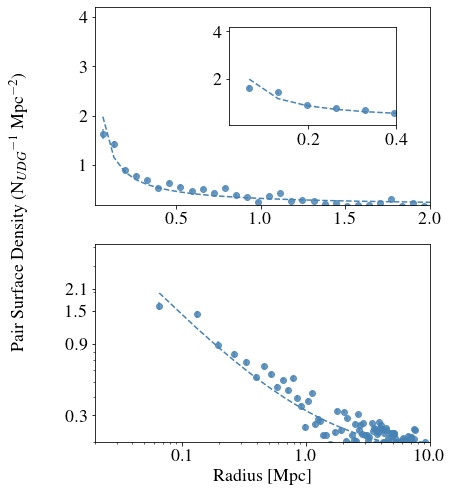

In [49]:
popt_power_all, pcov_power_all, popt_power_red, pcov_power_red, popt_power_blue, pcov_power_blue = surf_plot(x_prime_dim, y_prime_lin_val_dim, y_prime_lin_err_dim, y_r_lin_val_dim, y_r_lin_err_dim, y_b_lin_val_dim, y_b_lin_err_dim)

In [50]:
integral_all, integral_red, integral_blue = MC(popt_power_all, popt_power_red, popt_power_blue, UDG_num_dim, UDG_num_blue_dim, UDG_num_red_dim)
arr_all, arr_red, arr_blue = MC_plot(integral_all, integral_red, integral_blue)

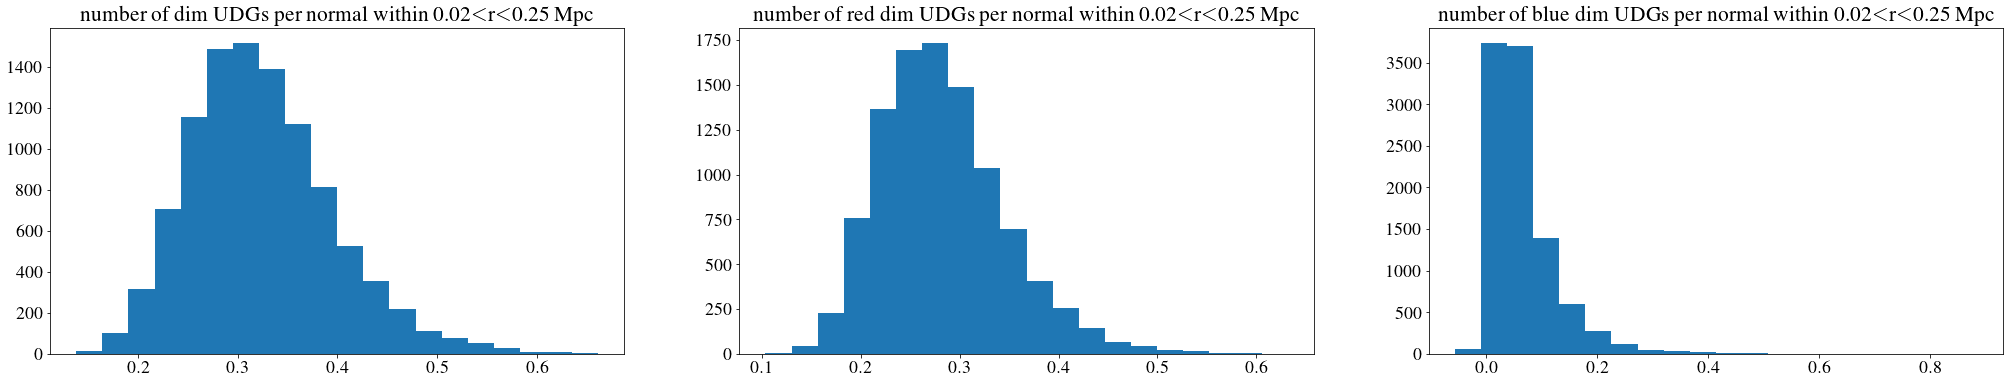

In [51]:
# Creates a histogram that shows the reuslts of Monte Carlo for all UDGs
fig, ax = plt.subplots(1, 3, figsize=(35, 6))
#integral_all.sort()
#fig, ax = plt.subplots()

integral_all.sort()
integral_red.sort()
integral_blue.sort()
st1 = 'number of dim UDGs per normal within ' + str(min_sep) + '$<$r$<$' + str(r_out) + ' Mpc'
st2 = 'number of red dim UDGs per normal within ' + str(min_sep) + '$<$r$<$' + str(r_out) + ' Mpc'
st3 = 'number of blue dim UDGs per normal within ' + str(min_sep) + '$<$r$<$' + str(r_out) + ' Mpc'

ax[0].set_title(st1)
all_hist = ax[0].hist(integral_all.data, bins=20)

ax[1].set_title(st2)
all_hist = ax[1].hist(integral_red.data, bins=20)

ax[2].set_title(st3)
all_hist = ax[2].hist(integral_blue.data, bins=20)

Number of dim UDGs per normal =  0.32 +  0.08 -  0.06
0.2540343821398213 0.31590397467372144 0.39238975055637104
uncertainty: 0.06186959253390012 to 0.0764857758826496
Number of dim red UDGs per normal =  0.28 +  0.07 -  0.05
0.22172105515052182 0.27514593139398014 0.34293203197096683
uncertainty: 0.05342487624345832 to 0.0677861005769867
Number of dim blue UDGs per normal =  0.05 +  0.06 -  0.03
0.020538145567196887 0.049585655606899516 0.11111980989116012
uncertainty: 0.02904751003970263 to 0.0615341542842606


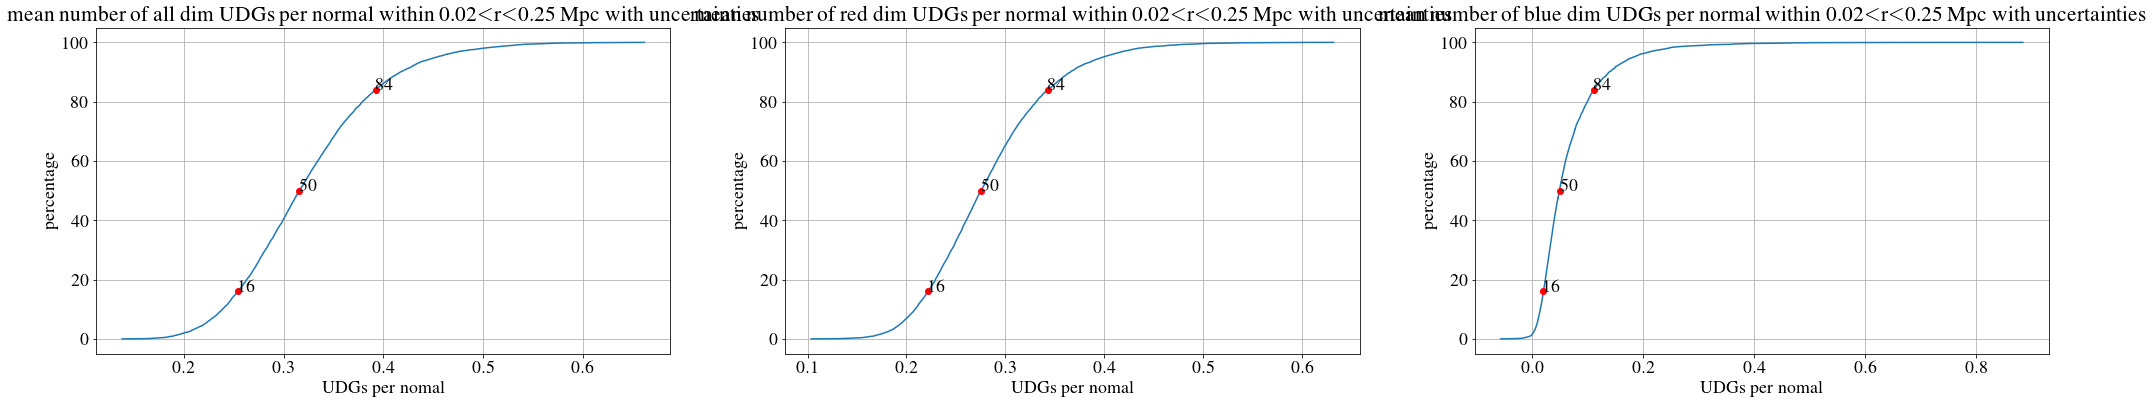

In [52]:
fig, ax = plt.subplots(1, 3, figsize=(35, 6))

st1 = 'mean number of all dim UDGs per normal within ' + str(min_sep) + '$<$r$<$' + str(r_out) + ' Mpc with uncertainties'
st2 = 'mean number of red dim UDGs per normal within ' + str(min_sep) + '$<$r$<$' + str(r_out) + ' Mpc with uncertainties'
st3 = 'mean number of blue dim UDGs per normal within ' + str(min_sep) + '$<$r$<$' + str(r_out) + ' Mpc with uncertainties'


ax[0].set_title(st1)
perc_all = np.array(arr_all/arr_all[-1])
ax[0].plot(integral_all, perc_all * 100)

# 16%
ax[0].plot(integral_all[find_nearest(perc_all, lower)], perc_all[find_nearest(perc_all, lower)] * 100, 'ro')
ax[0].text(integral_all[find_nearest(perc_all, lower)], perc_all[find_nearest(perc_all, lower)] * 100, ' 16%, ' + str('{0:.{1}f}'.format(integral_all[find_nearest(perc_all, lower)], 3)))

# 50%
ax[0].plot(integral_all[find_nearest(perc_all, middle)], perc_all[find_nearest(perc_all, middle)] * 100, 'ro')
ax[0].text(integral_all[find_nearest(perc_all, middle)], perc_all[find_nearest(perc_all, middle)] * 100, ' 50%, ' + str('{0:.{1}f}'.format(integral_all[find_nearest(perc_all, middle)], 3)))


# 86%
ax[0].plot(integral_all[find_nearest(perc_all, upper)], perc_all[find_nearest(perc_all, upper)] * 100, 'ro')
ax[0].text(integral_all[find_nearest(perc_all, upper)], perc_all[find_nearest(perc_all, upper)] * 100, ' 84%, '+ str('{0:.{1}f}'.format(integral_all[find_nearest(perc_all, upper)], 3)))

ax[0].set_ylabel('percentage')
ax[0].set_xlabel('UDGs per nomal')
ax[0].grid()

print('Number of dim UDGs per normal = %5.2f + %5.2f - %5.2f' %(integral_all[find_nearest(perc_all, middle)],integral_all[find_nearest(perc_all, upper)]-integral_all[find_nearest(perc_all, middle)],integral_all[find_nearest(perc_all, middle)]-integral_all[find_nearest(perc_all, lower)]))
print(integral_all[find_nearest(perc_all, lower)], integral_all[find_nearest(perc_all, middle)], integral_all[find_nearest(perc_all, upper)])
print('uncertainty:', (integral_all[find_nearest(perc_all, middle)]-(integral_all[find_nearest(perc_all, lower)])), 'to', (integral_all[find_nearest(perc_all, upper)]-(integral_all[find_nearest(perc_all, middle)])))


ax[1].set_title(st2)
perc_red = np.array(arr_red/arr_red[-1])
ax[1].plot(integral_red, perc_red * 100)

# 16%
ax[1].plot(integral_red[find_nearest(perc_red, lower)], perc_red[find_nearest(perc_red, lower)] * 100, 'ro')
ax[1].text(integral_red[find_nearest(perc_red, lower)], perc_red[find_nearest(perc_red, lower)] * 100, ' 16%, ' + str('{0:.{1}f}'.format(integral_red[find_nearest(perc_red, lower)], 3)))

# 50%
ax[1].plot(integral_red[find_nearest(perc_red, middle)], perc_red[find_nearest(perc_red, middle)] * 100, 'ro')
ax[1].text(integral_red[find_nearest(perc_red, middle)], perc_red[find_nearest(perc_red, middle)] * 100, ' 50%, ' + str('{0:.{1}f}'.format(integral_red[find_nearest(perc_red, middle)], 3)))


# 86%
ax[1].plot(integral_red[find_nearest(perc_red, upper)], perc_red[find_nearest(perc_red, upper)] * 100, 'ro')
ax[1].text(integral_red[find_nearest(perc_red, upper)], perc_red[find_nearest(perc_red, upper)] * 100, ' 84%, '+ str('{0:.{1}f}'.format(integral_red[find_nearest(perc_red, upper)], 3)))

ax[1].set_ylabel('percentage')
ax[1].set_xlabel('UDGs per nomal')
ax[1].grid()

print('Number of dim red UDGs per normal = %5.2f + %5.2f - %5.2f' %(integral_red[find_nearest(perc_red, middle)],integral_red[find_nearest(perc_red, upper)]-integral_red[find_nearest(perc_red, middle)],integral_red[find_nearest(perc_red, middle)]-integral_red[find_nearest(perc_red, lower)]))
print(integral_red[find_nearest(perc_red, lower)], integral_red[find_nearest(perc_red, middle)], integral_red[find_nearest(perc_red, upper)])
print('uncertainty:', (integral_red[find_nearest(perc_red, middle)]-(integral_red[find_nearest(perc_red, lower)])), 'to', (integral_red[find_nearest(perc_red, upper)]-(integral_red[find_nearest(perc_red, middle)])))

ax[2].set_title(st3)
perc_blue = np.array(arr_blue/arr_blue[-1])
ax[2].plot(integral_blue, perc_blue * 100)

# 16%
ax[2].plot(integral_blue[find_nearest(perc_blue, lower)], perc_blue[find_nearest(perc_blue, lower)] * 100, 'ro')
ax[2].text(integral_blue[find_nearest(perc_blue, lower)], perc_blue[find_nearest(perc_blue, lower)] * 100, ' 16%, ' + str('{0:.{1}f}'.format(integral_blue[find_nearest(perc_blue, lower)], 3)))

# 50%
ax[2].plot(integral_blue[find_nearest(perc_blue, middle)], perc_blue[find_nearest(perc_blue, middle)] * 100, 'ro')
ax[2].text(integral_blue[find_nearest(perc_blue, middle)], perc_blue[find_nearest(perc_blue, middle)] * 100, ' 50%, ' + str('{0:.{1}f}'.format(integral_blue[find_nearest(perc_blue, middle)], 3)))


# 86%
ax[2].plot(integral_blue[find_nearest(perc_blue, upper)], perc_blue[find_nearest(perc_blue, upper)] * 100, 'ro')
ax[2].text(integral_blue[find_nearest(perc_blue, upper)], perc_blue[find_nearest(perc_blue, upper)] * 100, ' 84%, '+ str('{0:.{1}f}'.format(integral_blue[find_nearest(perc_blue, upper)], 3)))

ax[2].set_ylabel('percentage')
ax[2].set_xlabel('UDGs per nomal')
ax[2].grid()

print('Number of dim blue UDGs per normal = %5.2f + %5.2f - %5.2f' %(integral_blue[find_nearest(perc_blue, middle)],integral_blue[find_nearest(perc_blue, upper)]-integral_blue[find_nearest(perc_blue, middle)],integral_blue[find_nearest(perc_blue, middle)]-integral_blue[find_nearest(perc_blue, lower)]))
print(integral_blue[find_nearest(perc_blue, lower)], integral_blue[find_nearest(perc_blue, middle)], integral_blue[find_nearest(perc_blue, upper)])
print('uncertainty:', (integral_blue[find_nearest(perc_blue, middle)]-(integral_blue[find_nearest(perc_blue, lower)])), 'to', (integral_blue[find_nearest(perc_blue, upper)]-(integral_blue[find_nearest(perc_blue, middle)])))



## bright UDGs

all UDGs constants:  [ 0.0841304  -0.85011878  0.11256208]
a = 0.08413040353339866 +/- 0.011219186789163052 
k = -0.8501187758968045 +/- 0.12702683821678443 
b = 0.11256207781989741 +/- 0.005923492235698089
red UDGs constants:  [ 0.10929815 -0.87327567  0.08430221]
a = 0.10929814785923261 +/- 0.013924128072072722 
k = -0.8732756673268487 +/- 0.10863699751339079 
b = 0.08430221227394688 +/- 0.006473019889423971
blue UDGs constants:  [1.59554610e-01 5.96710005e-03 5.01408905e-08]
a = 0.15955460987900724 +/- 242.79563560183104 
k = 0.005967100053385006 +/- 9.014395278960109 
b = 5.014089048040876e-08 +/- 242.79941036713134
N1 = 0.08824938787512046 , N2 = 0.02196006261828631 , N1/N2 = 4.01863097610817
36.912397473639416
N1 = 0.12040091452548572 , N2 = 0.016446763388270447 , N1/N2 = 7.32064490034274
29.83071206188825
N1 = 0.030782671586504027 , N2 = 9.782131922335331e-09 , N1/N2 = 3146826.461849141
5.248820649840161
all UDGs constants:  [ 0.0841304  -0.85011878  0.11256208]
a = 0.0841304035

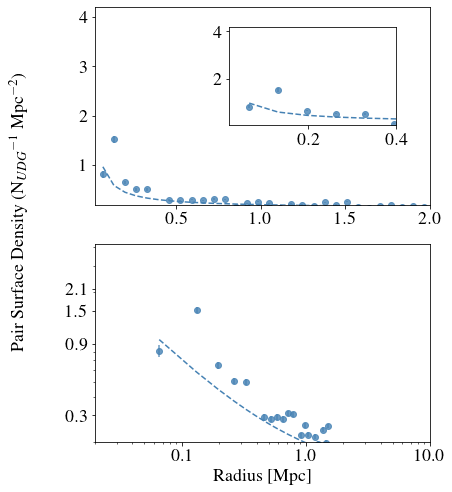

In [53]:
popt_power_all, pcov_power_all, popt_power_red, pcov_power_red, popt_power_blue, pcov_power_blue = surf_plot(x_prime_bright, y_prime_lin_val_bright, y_prime_lin_err_bright, y_r_lin_val_bright, y_r_lin_err_bright, y_b_lin_val_bright, y_b_lin_err_bright)

In [54]:
#integral_all, integral_red, integral_blue = MC(popt_power_all, popt_power_red, popt_power_blue, all_number_bright, all_blue_bright, all_red_bright)
integral_all, integral_red, integral_blue = MC(popt_power_all, popt_power_red, popt_power_blue, UDG_num_bright, UDG_num_blue_bright, UDG_num_red_bright)
arr_all, arr_red, arr_blue = MC_plot(integral_all, integral_red, integral_blue)

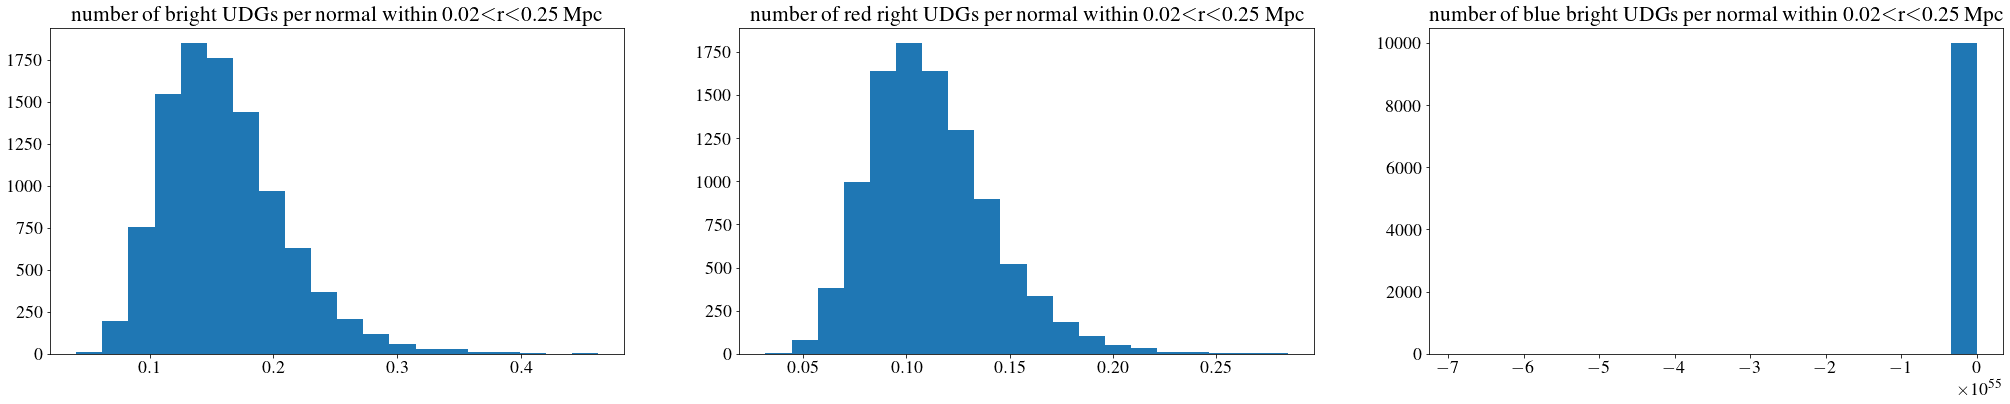

In [55]:
# Creates a histogram that shows the reuslts of Monte Carlo for all UDGs
fig, ax = plt.subplots(1, 3, figsize=(35, 6))
#integral_all.sort()
#fig, ax = plt.subplots()
integral_all.sort()
integral_red.sort()
integral_blue.sort()
st1 = 'number of bright UDGs per normal within ' + str(min_sep) + '$<$r$<$' + str(r_out) + ' Mpc'
st2 = 'number of red right UDGs per normal within ' + str(min_sep) + '$<$r$<$' + str(r_out) + ' Mpc'
st3 = 'number of blue bright UDGs per normal within ' + str(min_sep) + '$<$r$<$' + str(r_out) + ' Mpc'

ax[0].set_title(st1)
all_hist = ax[0].hist(integral_all.data, bins=20)

ax[1].set_title(st2)
all_hist = ax[1].hist(integral_red.data, bins=20)

ax[2].set_title(st3)
all_hist = ax[2].hist(integral_blue.data, bins=20)

Number of bright UDGs per normal =  0.15 +  0.05 -  0.04
0.11363859501923794 0.15344197483164812 0.20609302214466282
uncertainty: 0.03980337981241018 to 0.052651047313014704
Number of bright red UDGs per normal =  0.11 +  0.03 -  0.02
0.08382853809782351 0.10826291699857381 0.13969730354474416
uncertainty: 0.0244343789007503 to 0.031434386546170354
Number of bright blue UDGs per normal =  0.00 +  0.00 -  0.00
6.243453158414602e-08 3.395750971403767e-05 3.395750971403767e-05
uncertainty: 3.3895075182453524e-05 to 0.0


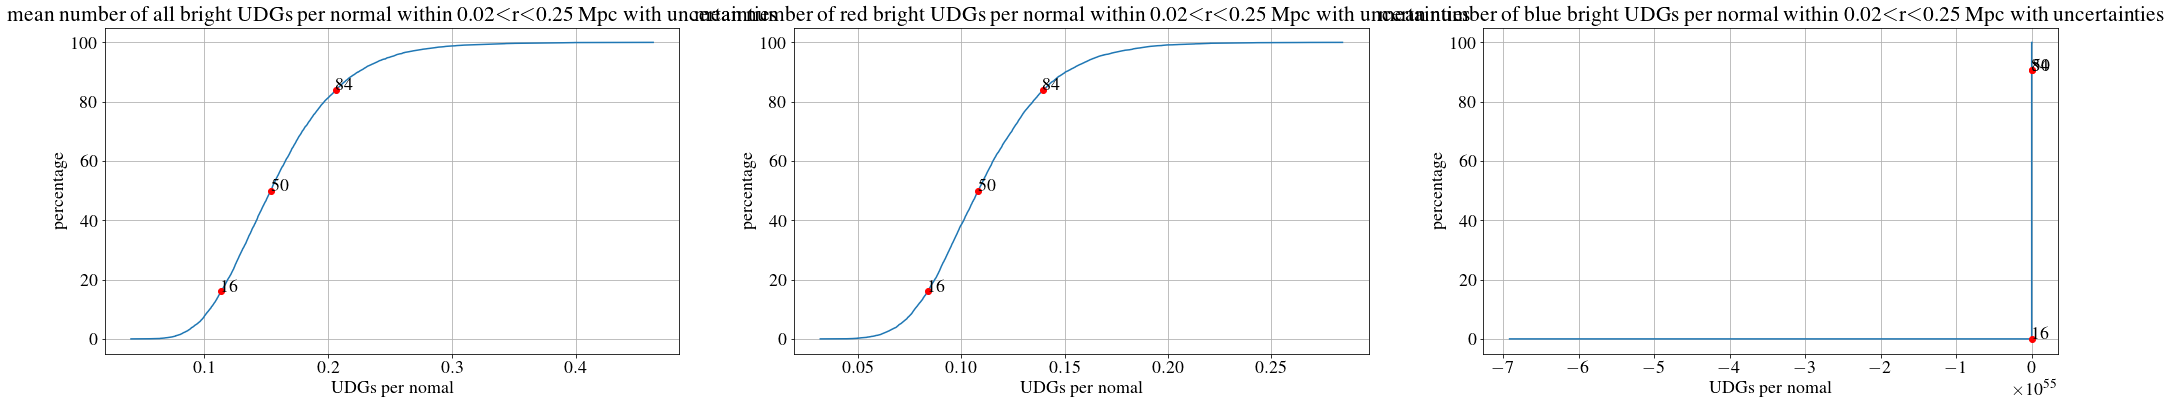

In [56]:
fig, ax = plt.subplots(1, 3, figsize=(35, 6))

st1 = 'mean number of all bright UDGs per normal within ' + str(min_sep) + '$<$r$<$' + str(r_out) + ' Mpc with uncertainties'
st2 = 'mean number of red bright UDGs per normal within ' + str(min_sep) + '$<$r$<$' + str(r_out) + ' Mpc with uncertainties'
st3 = 'mean number of blue bright UDGs per normal within ' + str(min_sep) + '$<$r$<$' + str(r_out) + ' Mpc with uncertainties'


ax[0].set_title(st1)
perc_all = np.array(arr_all/arr_all[-1])
ax[0].plot(integral_all, perc_all * 100)

# 16%
ax[0].plot(integral_all[find_nearest(perc_all, lower)], perc_all[find_nearest(perc_all, lower)] * 100, 'ro')
ax[0].text(integral_all[find_nearest(perc_all, lower)], perc_all[find_nearest(perc_all, lower)] * 100, ' 16%, ' + str('{0:.{1}f}'.format(integral_all[find_nearest(perc_all, lower)], 3)))

# 50%
ax[0].plot(integral_all[find_nearest(perc_all, middle)], perc_all[find_nearest(perc_all, middle)] * 100, 'ro')
ax[0].text(integral_all[find_nearest(perc_all, middle)], perc_all[find_nearest(perc_all, middle)] * 100, ' 50%, ' + str('{0:.{1}f}'.format(integral_all[find_nearest(perc_all, middle)], 3)))


# 86%
ax[0].plot(integral_all[find_nearest(perc_all, upper)], perc_all[find_nearest(perc_all, upper)] * 100, 'ro')
ax[0].text(integral_all[find_nearest(perc_all, upper)], perc_all[find_nearest(perc_all, upper)] * 100, ' 84%, '+ str('{0:.{1}f}'.format(integral_all[find_nearest(perc_all, upper)], 3)))

ax[0].set_ylabel('percentage')
ax[0].set_xlabel('UDGs per nomal')
ax[0].grid()

print('Number of bright UDGs per normal = %5.2f + %5.2f - %5.2f' %(integral_all[find_nearest(perc_all, middle)],integral_all[find_nearest(perc_all, upper)]-integral_all[find_nearest(perc_all, middle)],integral_all[find_nearest(perc_all, middle)]-integral_all[find_nearest(perc_all, lower)]))
print(integral_all[find_nearest(perc_all, lower)], integral_all[find_nearest(perc_all, middle)], integral_all[find_nearest(perc_all, upper)])
print('uncertainty:', (integral_all[find_nearest(perc_all, middle)]-(integral_all[find_nearest(perc_all, lower)])), 'to', (integral_all[find_nearest(perc_all, upper)]-(integral_all[find_nearest(perc_all, middle)])))


ax[1].set_title(st2)
perc_red = np.array(arr_red/arr_red[-1])
ax[1].plot(integral_red, perc_red * 100)

# 16%
ax[1].plot(integral_red[find_nearest(perc_red, lower)], perc_red[find_nearest(perc_red, lower)] * 100, 'ro')
ax[1].text(integral_red[find_nearest(perc_red, lower)], perc_red[find_nearest(perc_red, lower)] * 100, ' 16%, ' + str('{0:.{1}f}'.format(integral_red[find_nearest(perc_red, lower)], 3)))

# 50%
ax[1].plot(integral_red[find_nearest(perc_red, middle)], perc_red[find_nearest(perc_red, middle)] * 100, 'ro')
ax[1].text(integral_red[find_nearest(perc_red, middle)], perc_red[find_nearest(perc_red, middle)] * 100, ' 50%, ' + str('{0:.{1}f}'.format(integral_red[find_nearest(perc_red, middle)], 3)))


# 86%
ax[1].plot(integral_red[find_nearest(perc_red, upper)], perc_red[find_nearest(perc_red, upper)] * 100, 'ro')
ax[1].text(integral_red[find_nearest(perc_red, upper)], perc_red[find_nearest(perc_red, upper)] * 100, ' 84%, '+ str('{0:.{1}f}'.format(integral_red[find_nearest(perc_red, upper)], 3)))

ax[1].set_ylabel('percentage')
ax[1].set_xlabel('UDGs per nomal')
ax[1].grid()

print('Number of bright red UDGs per normal = %5.2f + %5.2f - %5.2f' %(integral_red[find_nearest(perc_red, middle)],integral_red[find_nearest(perc_red, upper)]-integral_red[find_nearest(perc_red, middle)],integral_red[find_nearest(perc_red, middle)]-integral_red[find_nearest(perc_red, lower)]))
print(integral_red[find_nearest(perc_red, lower)], integral_red[find_nearest(perc_red, middle)], integral_red[find_nearest(perc_red, upper)])
print('uncertainty:', (integral_red[find_nearest(perc_red, middle)]-(integral_red[find_nearest(perc_red, lower)])), 'to', (integral_red[find_nearest(perc_red, upper)]-(integral_red[find_nearest(perc_red, middle)])))

ax[2].set_title(st3)
perc_blue = np.array(arr_blue/arr_blue[-1])
ax[2].plot(integral_blue, perc_blue * 100)

# 16%
ax[2].plot(integral_blue[find_nearest(perc_blue, lower)], perc_blue[find_nearest(perc_blue, lower)] * 100, 'ro')
ax[2].text(integral_blue[find_nearest(perc_blue, lower)], perc_blue[find_nearest(perc_blue, lower)] * 100, ' 16%, ' + str('{0:.{1}f}'.format(integral_blue[find_nearest(perc_blue, lower)], 3)))

# 50%
ax[2].plot(integral_blue[find_nearest(perc_blue, middle)], perc_blue[find_nearest(perc_blue, middle)] * 100, 'ro')
ax[2].text(integral_blue[find_nearest(perc_blue, middle)], perc_blue[find_nearest(perc_blue, middle)] * 100, ' 50%, ' + str('{0:.{1}f}'.format(integral_blue[find_nearest(perc_blue, middle)], 3)))


# 86%
ax[2].plot(integral_blue[find_nearest(perc_blue, upper)], perc_blue[find_nearest(perc_blue, upper)] * 100, 'ro')
ax[2].text(integral_blue[find_nearest(perc_blue, upper)], perc_blue[find_nearest(perc_blue, upper)] * 100, ' 84%, '+ str('{0:.{1}f}'.format(integral_blue[find_nearest(perc_blue, upper)], 3)))

ax[2].set_ylabel('percentage')
ax[2].set_xlabel('UDGs per nomal')
ax[2].grid()

print('Number of bright blue UDGs per normal = %5.2f + %5.2f - %5.2f' %(integral_blue[find_nearest(perc_blue, middle)],integral_blue[find_nearest(perc_blue, upper)]-integral_blue[find_nearest(perc_blue, middle)],integral_blue[find_nearest(perc_blue, middle)]-integral_blue[find_nearest(perc_blue, lower)]))
print(integral_blue[find_nearest(perc_blue, lower)], integral_blue[find_nearest(perc_blue, middle)], integral_blue[find_nearest(perc_blue, upper)])
print('uncertainty:', (integral_blue[find_nearest(perc_blue, middle)]-(integral_blue[find_nearest(perc_blue, lower)])), 'to', (integral_blue[find_nearest(perc_blue, upper)]-(integral_blue[find_nearest(perc_blue, middle)])))



## UDGs in magnitude bin (only the all is valid ; red & blue numbers are junk)

all UDGs constants:  [ 0.01025963 -1.38273813  0.05101374]
a = 0.010259629808573542 +/- 0.0048615954245342895 
k = -1.3827381255005844 +/- 0.2588998179280386 
b = 0.051013744667140516 +/- 0.0011865373982009471
red UDGs constants:  [ 0.01732535 -1.38274582  0.08614748]
a = 0.017325346783021573 +/- 0.00820980152590812 
k = -1.38274581871225 +/- 0.25890012891740144 
b = 0.08614747610659533 +/- 0.002003700704159954
blue UDGs constants:  [ 0.02515361 -1.38281632  0.12508575]
a = 0.02515361344199834 +/- 0.011920214748134362 
k = -1.3828163215903988 +/- 0.25890297572233384 
b = 0.12508575416957082 +/- 0.0029091228368468064
N1 = 0.035047275221101286 , N2 = 0.009952419580208276 , N1/N2 = 3.5214828855083145
32.34593490651544
N1 = 0.05918508849430704 , N2 = 0.016806761267636673 , N1/N2 = 3.52150468206356
32.35571735233813
N1 = 0.08594135569490745 , N2 = 0.024403343003444267 , N1/N2 = 3.5217042059679184
32.33422989451513
all UDGs constants:  [ 0.01025963 -1.38273813  0.05101374]
a = 0.010259629808

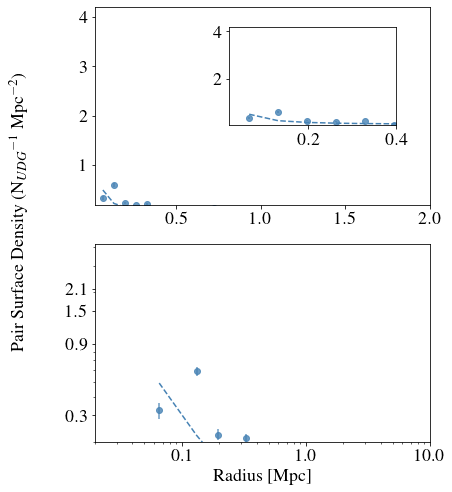

In [57]:

popt_power_all, pcov_power_all, popt_power_red, pcov_power_red, popt_power_blue, pcov_power_blue = surf_plot(x_prime_bin, y_prime_lin_val_bin, y_prime_lin_err_bin, y_r_lin_val_bin, y_r_lin_err_bin, y_b_lin_val_bin, y_b_lin_err_bin)


In [58]:
integral_all, integral_red, integral_blue = MC(popt_power_all, popt_power_all, popt_power_all, UDG_num_bin, UDG_num_bin, UDG_num_bin)
integral_all = integral_all[(integral_all<20) & (integral_all>=-20)]
arr_all, arr_red, arr_blue = MC_plot(integral_all, integral_red, integral_blue)


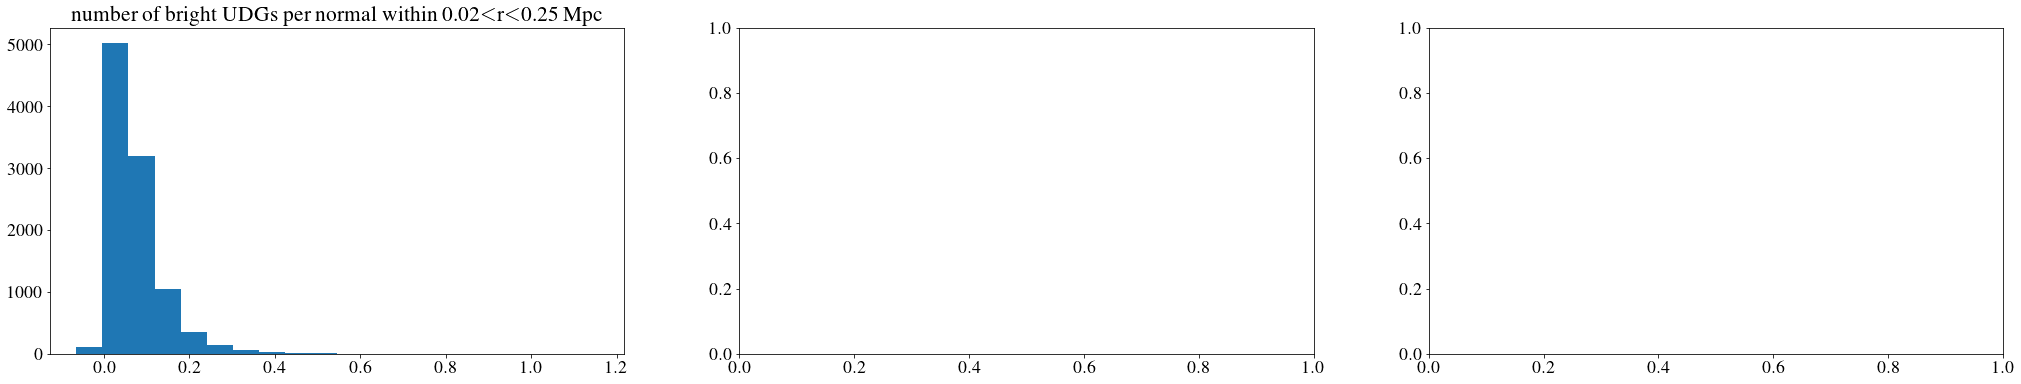

In [59]:
# Creates a histogram that shows the reuslts of Monte Carlo for all UDGs
fig, ax = plt.subplots(1, 3, figsize=(35, 6))
#integral_all.sort()
#fig, ax = plt.subplots()

integral_all.sort()
arr_all.sort()
#integral_red.sort()
#integral_blue.sort()
st1 = 'number of bright UDGs per normal within ' + str(min_sep) + '$<$r$<$' + str(r_out) + ' Mpc'
#st2 = 'number of red right UDGs per normal within ' + str(min_sep) + '$<$r$<$' + str(r_out) + ' Mpc'
#st3 = 'number of blue bright UDGs per normal within ' + str(min_sep) + '$<$r$<$' + str(r_out) + ' Mpc'

ax[0].set_title(st1)

all_hist = ax[0].hist(integral_all.data, bins=20)

#ax[1].set_title(st2)
#all_hist = ax[1].hist(integral_red.data, bins=20)

#ax[2].set_title(st3)
#all_hist = ax[2].hist(integral_blue.data, bins=20)

Number of bright UDGs per normal =  0.05 +  0.07 -  0.03
0.024346291870195557 0.05499795059940659 0.12138235236433027
uncertainty: 0.030651658729211034 to 0.06638440176492369


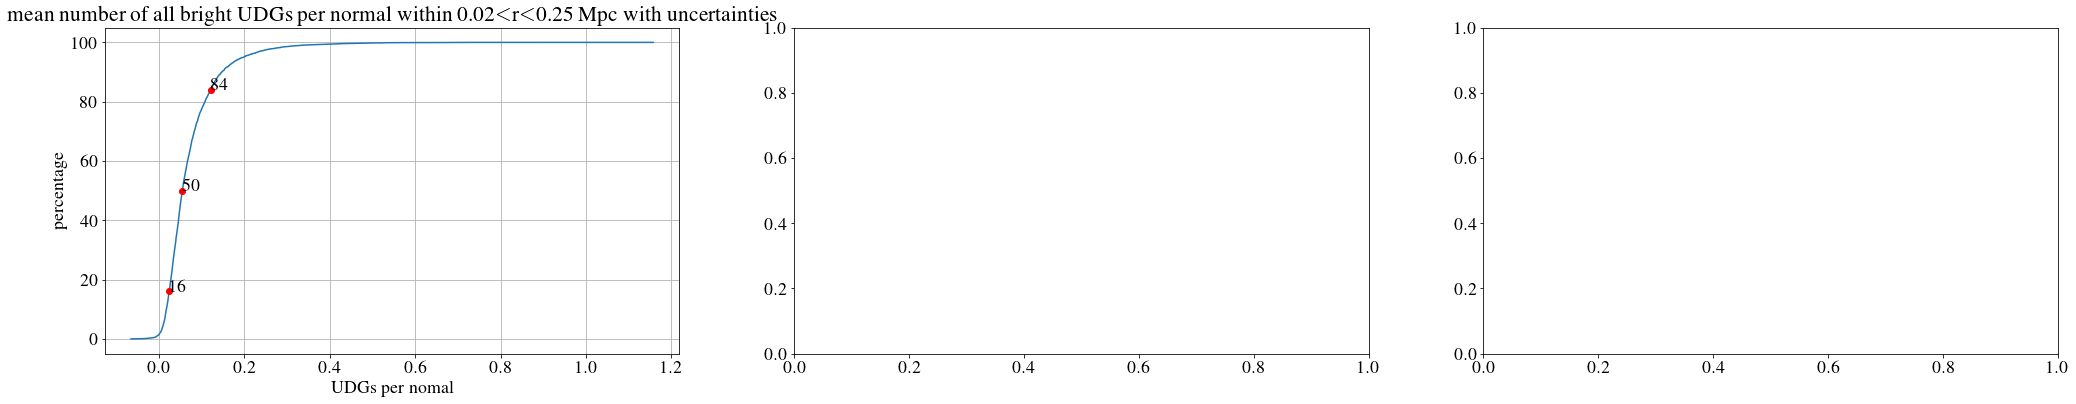

In [60]:
fig, ax = plt.subplots(1, 3, figsize=(35, 6))

st1 = 'mean number of all bright UDGs per normal within ' + str(min_sep) + '$<$r$<$' + str(r_out) + ' Mpc with uncertainties'
st2 = 'mean number of red bright UDGs per normal within ' + str(min_sep) + '$<$r$<$' + str(r_out) + ' Mpc with uncertainties'
st3 = 'mean number of blue bright UDGs per normal within ' + str(min_sep) + '$<$r$<$' + str(r_out) + ' Mpc with uncertainties'


ax[0].set_title(st1)

perc_all = np.array(arr_all/arr_all[-1])
ax[0].plot(integral_all, perc_all * 100)

# 16%
ax[0].plot(integral_all[find_nearest(perc_all, lower)], perc_all[find_nearest(perc_all, lower)] * 100, 'ro')
ax[0].text(integral_all[find_nearest(perc_all, lower)], perc_all[find_nearest(perc_all, lower)] * 100, ' 16%, ' + str('{0:.{1}f}'.format(integral_all[find_nearest(perc_all, lower)], 3)))

# 50%
ax[0].plot(integral_all[find_nearest(perc_all, middle)], perc_all[find_nearest(perc_all, middle)] * 100, 'ro')
ax[0].text(integral_all[find_nearest(perc_all, middle)], perc_all[find_nearest(perc_all, middle)] * 100, ' 50%, ' + str('{0:.{1}f}'.format(integral_all[find_nearest(perc_all, middle)], 3)))


# 86%
ax[0].plot(integral_all[find_nearest(perc_all, upper)], perc_all[find_nearest(perc_all, upper)] * 100, 'ro')
ax[0].text(integral_all[find_nearest(perc_all, upper)], perc_all[find_nearest(perc_all, upper)] * 100, ' 84%, '+ str('{0:.{1}f}'.format(integral_all[find_nearest(perc_all, upper)], 3)))

ax[0].set_ylabel('percentage')
ax[0].set_xlabel('UDGs per nomal')
ax[0].grid()

print('Number of bright UDGs per normal = %5.2f + %5.2f - %5.2f' %(integral_all[find_nearest(perc_all, middle)],integral_all[find_nearest(perc_all, upper)]-integral_all[find_nearest(perc_all, middle)],integral_all[find_nearest(perc_all, middle)]-integral_all[find_nearest(perc_all, lower)]))
print(integral_all[find_nearest(perc_all, lower)], integral_all[find_nearest(perc_all, middle)], integral_all[find_nearest(perc_all, upper)])
print('uncertainty:', (integral_all[find_nearest(perc_all, middle)]-(integral_all[find_nearest(perc_all, lower)])), 'to', (integral_all[find_nearest(perc_all, upper)]-(integral_all[find_nearest(perc_all, middle)])))


#ax[1].set_title(st2)
#perc_red = np.array(arr_red/arr_red[-1])
#ax[1].plot(integral_red, perc_red * 100)

# 16%
#ax[1].plot(integral_red[find_nearest(perc_red, lower)], perc_red[find_nearest(perc_red, lower)] * 100, 'ro')
#ax[1].text(integral_red[find_nearest(perc_red, lower)], perc_red[find_nearest(perc_red, lower)] * 100, ' 16%, ' + str('{0:.{1}f}'.format(integral_red[find_nearest(perc_red, lower)], 3)))

# 50%
#ax[1].plot(integral_red[find_nearest(perc_red, middle)], perc_red[find_nearest(perc_red, middle)] * 100, 'ro')
#ax[1].text(integral_red[find_nearest(perc_red, middle)], perc_red[find_nearest(perc_red, middle)] * 100, ' 50%, ' + str('{0:.{1}f}'.format(integral_red[find_nearest(perc_red, middle)], 3)))


# 86%
#ax[1].plot(integral_red[find_nearest(perc_red, upper)], perc_red[find_nearest(perc_red, upper)] * 100, 'ro')
#ax[1].text(integral_red[find_nearest(perc_red, upper)], perc_red[find_nearest(perc_red, upper)] * 100, ' 84%, '+ str('{0:.{1}f}'.format(integral_red[find_nearest(perc_red, upper)], 3)))

#ax[1].set_ylabel('percentage')
#ax[1].set_xlabel('UDGs per nomal')
#ax[1].grid()

#print('Number of bright red UDGs per normal = %5.2f + %5.2f - %5.2f' %(integral_red[find_nearest(perc_red, middle)],integral_red[find_nearest(perc_red, upper)]-integral_red[find_nearest(perc_red, middle)],integral_red[find_nearest(perc_red, middle)]-integral_red[find_nearest(perc_red, lower)]))
#print(integral_red[find_nearest(perc_red, lower)], integral_red[find_nearest(perc_red, middle)], integral_red[find_nearest(perc_red, upper)])
#print('uncertainty:', (integral_red[find_nearest(perc_red, middle)]-(integral_red[find_nearest(perc_red, lower)])), 'to', (integral_red[find_nearest(perc_red, upper)]-(integral_red[find_nearest(perc_red, middle)])))

#ax[2].set_title(st3)
#perc_blue = np.array(arr_blue/arr_blue[-1])
#ax[2].plot(integral_blue, perc_blue * 100)

# 16%
#ax[2].plot(integral_blue[find_nearest(perc_blue, lower)], perc_blue[find_nearest(perc_blue, lower)] * 100, 'ro')
#ax[2].text(integral_blue[find_nearest(perc_blue, lower)], perc_blue[find_nearest(perc_blue, lower)] * 100, ' 16%, ' + str('{0:.{1}f}'.format(integral_blue[find_nearest(perc_blue, lower)], 3)))

# 50%
#ax[2].plot(integral_blue[find_nearest(perc_blue, middle)], perc_blue[find_nearest(perc_blue, middle)] * 100, 'ro')
#ax[2].text(integral_blue[find_nearest(perc_blue, middle)], perc_blue[find_nearest(perc_blue, middle)] * 100, ' 50%, ' + str('{0:.{1}f}'.format(integral_blue[find_nearest(perc_blue, middle)], 3)))


# 86%
#ax[2].plot(integral_blue[find_nearest(perc_blue, upper)], perc_blue[find_nearest(perc_blue, upper)] * 100, 'ro')
#ax[2].text(integral_blue[find_nearest(perc_blue, upper)], perc_blue[find_nearest(perc_blue, upper)] * 100, ' 84%, '+ str('{0:.{1}f}'.format(integral_blue[find_nearest(perc_blue, upper)], 3)))

#ax[2].set_ylabel('percentage')
#ax[2].set_xlabel('UDGs per nomal')
#ax[2].grid()

#print('Number of bright blue UDGs per normal = %5.2f + %5.2f - %5.2f' %(integral_blue[find_nearest(perc_blue, middle)],integral_blue[find_nearest(perc_blue, upper)]-integral_blue[find_nearest(perc_blue, middle)],integral_blue[find_nearest(perc_blue, middle)]-integral_blue[find_nearest(perc_blue, lower)]))
#print(integral_blue[find_nearest(perc_blue, lower)], integral_blue[find_nearest(perc_blue, middle)], integral_blue[find_nearest(perc_blue, upper)])
#print('uncertainty:', (integral_blue[find_nearest(perc_blue, middle)]-(integral_blue[find_nearest(perc_blue, lower)])), 'to', (integral_blue[find_nearest(perc_blue, upper)]-(integral_blue[find_nearest(perc_blue, middle)])))

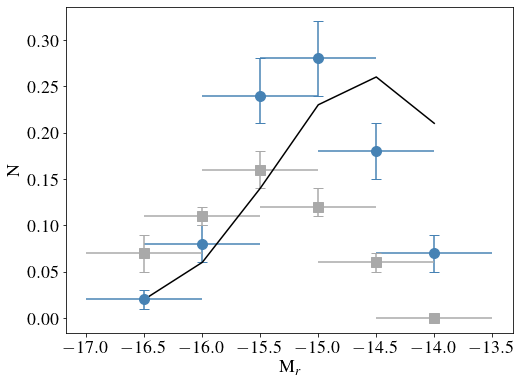

In [62]:

sats = pd.read_csv("sat_lf.csv")

fig, ax = plt.subplots(figsize=(8,6))
plt.xlabel(xlabel='M$_r$', fontsize=18)
plt.ylabel('N')

yerror = [sats['lfive'],sats['ufive']]
plt.errorbar(sats['mag'],sats['five'],xerr = 0.0, yerr = 0, c='black',capsize=None)
#plt.bar(sats['mag'],sats['five'],1,alpha=0.5)

yerror = [sats['lsix'],sats['usix']]
plt.errorbar(sats['mag'],sats['six'], yerr = yerror, c='steelblue', fmt='o',capsize=5, markersize=10)
plt.errorbar(sats['mag'],sats['six'], xerr = 0.5, c='steelblue', fmt='o',capsize=None)


yerror = [sats['lseven'],sats['useven']]
plt.errorbar(sats['mag'],sats['seven'],yerr = yerror, c='darkgrey', fmt='s',capsize=5,markersize=10)
plt.errorbar(sats['mag'],sats['seven'],xerr = 0.5, c='darkgrey', fmt='s',capsize=None)


plt.savefig('figurex.png',format='png',dpi=200,bbox_inches='tight')

<ErrorbarContainer object of 3 artists>

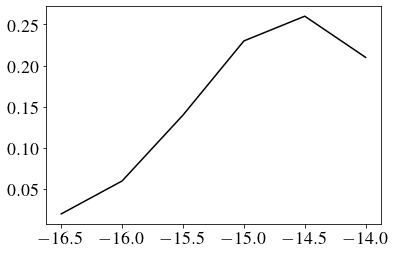

In [63]:
plt.errorbar(sats['mag'],sats['five'],xerr = 0.0, yerr = 0, c='black',capsize=None)

In [64]:
sats['mag']

0   -16.5
1   -16.0
2   -15.5
3   -15.0
4   -14.5
5   -14.0
Name: mag, dtype: float64

In [65]:
sats['five']

0    0.02
1    0.06
2    0.14
3    0.23
4    0.26
5    0.21
Name: five, dtype: float64

In [ ]:
yerror = [sats['lfive'],sats['ufive']]
plt.errorbar(sats['mag'],sats['five'],xerr = 0.0, yerr = 0, c='black',capsize=None)